In [1]:
import time
import sys
import os
import stable_baselines3
import gymnasium as gym
import numpy as np
import jsbsim
from gymnasium import spaces
import math

print("Gym version:", gym.__version__)
print("Stable-Baselines3 version:", stable_baselines3.__version__)
print("JSBSim installed successfully!")

2025-03-23 10:16:52.091761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742750212.150490     996 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742750212.166787     996 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 10:16:52.313172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Gym version: 1.0.0
Stable-Baselines3 version: 2.5.0
JSBSim installed successfully!


In [ ]:
sim_ownship = jsbsim.FGFDMExec("/home/sezhou/aienv/lib/python3.10/site-packages/jsbsim")
sim_ownship.load_model("f16")

In [ ]:
sim_target = jsbsim.FGFDMExec("/home/sezhou/aienv/lib/python3.10/site-packages/jsbsim")
sim_target.load_model("f16")

In [4]:
print(sim_ownship.query_property_catalog("theta-deg"))

attitude/theta-deg (R)
ic/theta-deg (RW)



In [5]:
# Helper functions for the environment

import random
def roll_correction_cmd(desired_roll, current_roll, k_roll=0.05):
    # keeps roll at desired level
    roll_error = desired_roll - current_roll
    # Apply a proportional control to keep roll stable
    roll_cmd = np.clip(roll_error * k_roll, -1.0, 1.0)
    return roll_cmd

def roll_correction_cmd_limit_left(current_roll, k_roll=0.001):
    """
    Prevent unnecessary left rolls (negative roll). Correct based on quadrant:
    - Slight left roll → roll back right to 0°
    - Deep inverted left roll → continue left roll toward +180° (upright inverted)

    Parameters:
    - current_roll: Current roll angle [-180, 180] deg
    - k_roll: Proportional gain

    Returns:
    - roll_cmd: Correction command [-1, 1] or None if no correction needed
    """
    if -90 < current_roll < 0:
        # Slight left roll: roll right back to 0°
        roll_error = -current_roll  # Target roll = 0°
        roll_cmd = np.clip(roll_error * k_roll, 0.0, 1.0)  # Positive roll command
        return roll_cmd

    elif -180 < current_roll <= -90:
        # Deep inverted left: continue left roll toward -180° → 180°
        roll_error = -180 - current_roll  # Target roll = -180°
        roll_cmd = np.clip(roll_error * k_roll, -1.0, 0.0)  # Negative roll command
        return roll_cmd

    else:
        # No correction needed
        return None

def haversine(lat1, lon1, lat2, lon2):
    """Compute approximate distance (in meters) between two lat-long points."""
    R = 6371000  # Earth radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in meters

def angular_difference(new_angle, old_angle):
    """Compute the smallest difference between two angles, handling wraparound at ±180°."""
    return ((new_angle - old_angle + 180) % 360) - 180

In [62]:
class F16LeadPursuitEnv(gym.Env):
    def __init__(self, stabilize_roll=True, jsbsim_step_size=30, max_steps=150, target_pull=(-1.0, -0.5), target_roll=(45.0, 90.0), roll_assist=False):
        super(F16LeadPursuitEnv, self).__init__()

        # Use preloaded JSBSim models instead of reloading them
        self.sim_ownship = sim_ownship
        self.sim_target = sim_target

        # Control space
        throttle = (0, 1)
        pitch = (0, 1)
        roll = (-1, 1)
        controls = [throttle, pitch, roll]
        self.action_space = spaces.Box(
            low=np.array([control[0] for control in controls]),
            high=np.array([control[1] for control in controls]),
            dtype=np.float32
        )

        # Observation space
        observations = [
            "los_x", "los_y", "los_z", # line of sight from own ship to target
            "distance", 
            "oh_x", "oh_y", "oh_z", # own heading vector 
            "th_x", "th_y", "th_z", # target heading vector 
            "own_alt", "tgt_alt", 
            "own_speed", "tgt_speed"
        ]
        self.observation_space = spaces.Box(low=np.array([-1 for observation in observations]), 
                                            high=np.array([1 for observation in observations]), 
                                            dtype=np.float32)
        
        self.steps = 0
        self.stabilize_roll = stabilize_roll
        self.jsbsim_step_size = jsbsim_step_size # number of jsbsim frames per step in this env
        self.max_steps = max_steps
        self.target_pull = target_pull
        self.target_roll = target_roll
        self.roll_assist = roll_assist 
        self.jsbsim_second_per_step = 0.00833
        self.gym_second_per_step = self.jsbsim_step_size * self.jsbsim_second_per_step

    def reset(self, seed=None, options=None):
        """Reset the environment and reset both aircraft."""
        super().reset(seed=seed)  

        self.sim_ownship.reset_to_initial_conditions(0)
        self.sim_target.reset_to_initial_conditions(0)

        # Set initial velocity (ft/s)
        self.sim_ownship["ic/vt-fps"] = 1400
        self.sim_target["ic/vt-fps"] = 900

        # Use precise positioning via JSBSim's coordinate frame
        self.sim_ownship["ic/lat-gc-deg"] = 0.0  # Equator for simplicity
        self.sim_ownship["ic/long-gc-deg"] = 0.0  # Reference point
        self.sim_ownship["ic/h-sl-ft"] = 30000  
        self.init_lat = 0.0
        self.init_lon = 0.0
        self.init_alt = 30000

        # Correctly offset target aircraft using meters per degree latitude (~111km)
        self.sim_target["ic/lat-gc-deg"] = 2000.0 / 111000.0  # 2000m ahead
        self.sim_target["ic/long-gc-deg"] = 0.0
        self.sim_target["ic/h-sl-ft"] = 30000  

        # Set aircraft orientation (Level flight)
        self.desired_roll = random.uniform(self.target_roll[0], self.target_roll[1])  # roll angle
        self.sim_ownship["ic/theta-deg"] = 0.0
        self.sim_ownship["ic/phi-deg"] = 0.0
        self.sim_ownship["ic/psi-true-deg"] = 0.0

        self.sim_target["ic/theta-deg"] = 0.0
        self.sim_target["ic/phi-deg"] = self.desired_roll
        self.sim_target["ic/psi-true-deg"] = 0.0

         # Ensure engine is properly started
        self.sim_ownship["propulsion/cutoff_cmd"] = 0  # Allow fuel
        self.sim_ownship["propulsion/starter_cmd"] = 1  # Start engine
        self.sim_ownship["propulsion/engine/set-running"] = 1  # Ensure running
        self.sim_ownship["fcs/throttle-cmd-norm"] = 0.7  # Apply throttle for startup
    
        # Repeat for target aircraft
        self.sim_target["propulsion/cutoff_cmd"] = 0
        self.sim_target["propulsion/starter_cmd"] = 1
        self.sim_target["propulsion/engine/set-running"] = 1
        self.sim_target["fcs/throttle-cmd-norm"] = 0.7  

        # Stick
        self.sim_ownship["fcs/elevator-cmd-norm"] = -0.05
        self.sim_target["fcs/elevator-cmd-norm"] = random.uniform(self.target_pull[0], self.target_pull[1]) # target pulls and turns right
        self.sim_ownship["fcs/aileron-cmd-norm"] = 0.0
        self.sim_target["fcs/aileron-cmd-norm"] = 0.0

        # Run initial conditions
        self.sim_ownship.run_ic()
        self.sim_target.run_ic()

        print("Initial conditions set. Starting simulation...")
        self.sim_ownship.run()
        self.sim_target.run()

        self.steps = 0
        self.prev_aon = 0.0
        self.prev_aspect = 0.0
        self.prev_throttle = 0.7
        self.prev_pitch = -0.05

        return self._get_obs(), {}

    def step(self, action):
        """Step the environment forward."""
        throttle = np.clip(action[0], 0.0, 1.0)
        pitch = np.clip(action[1], -1.0, 1.0)
        roll = np.clip(action[2], -1.0, 1.0)
        self.sim_ownship["fcs/throttle-cmd-norm"] = throttle
        self.sim_ownship["fcs/elevator-cmd-norm"] = pitch
        self.sim_ownship["fcs/aileron-cmd-norm"] = roll

        # step simulation
        for i in range(self.jsbsim_step_size):
            # Need to correct roll so the aircraft stays relatively level (phi-deg is roll)
            if self.stabilize_roll:
                # stabilize target roll
                self.sim_target["fcs/aileron-cmd-norm"] = roll_correction_cmd(self.desired_roll, self.sim_target["attitude/phi-deg"])
            if self.roll_assist:
                # training wheels to prevent left roll
                ownship_roll_correction = roll_correction_cmd_limit_left(self.sim_ownship["attitude/phi-deg"], k_roll=0.05)
                if ownship_roll_correction != None:
                    self.sim_ownship["fcs/aileron-cmd-norm"] = ownship_roll_correction 
            self.sim_ownship.run()
            self.sim_target.run()

        obs = self._get_obs() # need to call this to update the metrics stored in self

        # Universal BFM function
        # Positional reward 1/(1+k(distance - d_ideal)^2) * cos(aspect)
        d_ideal = 500
        k1 = 0.0001
        k2 = 0.001
        k4 = 0.05
        aspect_cosine = max(np.cos(np.radians(self.aspect)), 0)
        ao_cosine = max(np.cos(np.radians(self.angle_off)), 0)
        r_position = 1.0 / (1.0 + k1 * (self.distance - d_ideal)**2) * aspect_cosine * ao_cosine
        
        reward = r_position

        own_alt = sim_ownship["position/h-sl-ft"]
        crashed = False
        if own_alt < 1000:
            reward -= 20
            crashed = True
    
        self.steps += 1
        done = self.steps > self.max_steps or crashed
        truncated = False

        return obs, reward, done, truncated, {}

    def _get_obs(self):
        """Retrieve the latest 3D observations from JSBSim."""
        
        # --- 1. Constants ---
        meters_per_degree_lat = 111000
        meters_per_degree_lon = lambda lat: 111000 * np.cos(np.radians(lat))
        meters_per_feet = 0.3048

        lat0, lon0 = self.init_lat, self.init_lon
        alt0 = self.init_alt

        # --- 2. Ownship & Target Positions (relative XYZ in meters) ---
        lat_own = self.sim_ownship["position/lat-gc-deg"]
        lon_own = self.sim_ownship["position/long-gc-deg"]
        alt_own = self.sim_ownship["position/h-sl-ft"]
        self.own_alt = alt_own

        lat_tgt = self.sim_target["position/lat-gc-deg"]
        lon_tgt = self.sim_target["position/long-gc-deg"]
        alt_tgt = self.sim_target["position/h-sl-ft"]
        self.tgt_alt = alt_tgt

        own_x = (lon_own - lon0) * meters_per_degree_lon(lat0)
        own_y = (lat_own - lat0) * meters_per_degree_lat
        own_z = (alt_own - alt0) * meters_per_feet

        tgt_x = (lon_tgt - lon0) * meters_per_degree_lon(lat0)
        tgt_y = (lat_tgt - lat0) * meters_per_degree_lat
        tgt_z = (alt_tgt - alt0) * meters_per_feet

        own_pos = np.array([own_x, own_y, own_z])
        tgt_pos = np.array([tgt_x, tgt_y, tgt_z])
        self.own_pos = own_pos
        self.tgt_pos = tgt_pos

        # --- 3. LOS Vector & Distance ---
        los_vec = tgt_pos - own_pos
        los_distance = np.linalg.norm(los_vec)
        los_dir = los_vec / los_distance
        self.los_dir = los_dir
        self.distance = los_distance

        # --- 4. Nose Vectors ---
        # Store corrected aircraft headings
        own_heading_rad = np.radians((450 - self.sim_ownship["attitude/psi-deg"]) % 360)
        own_pitch_rad = np.radians(self.sim_ownship["attitude/theta-deg"])

        tgt_heading_rad = np.radians((450 - self.sim_target["attitude/psi-deg"]) % 360)
        tgt_pitch_rad = np.radians(self.sim_target["attitude/theta-deg"])

        own_nose = np.array([
            np.cos(own_pitch_rad) * np.cos(own_heading_rad),
            np.cos(own_pitch_rad) * np.sin(own_heading_rad),
            np.sin(own_pitch_rad)
        ])

        tgt_nose = np.array([
            np.cos(tgt_pitch_rad) * np.cos(tgt_heading_rad),
            np.cos(tgt_pitch_rad) * np.sin(tgt_heading_rad),
            np.sin(tgt_pitch_rad)
        ])

        self.own_nose = own_nose
        self.tgt_nose = tgt_nose

        # --- 5. AON ---
        aon = np.degrees(np.arccos(np.clip(np.dot(own_nose, los_dir), -1.0, 1.0)))
        self.aon = aon

        # --- 6. Aspect ---
        aspect_raw = np.degrees(np.arccos(np.clip(np.dot(tgt_nose, los_dir), -1.0, 1.0)))
        aspect = np.clip(aspect_raw, 0, 180)
        self.aspect = aspect

        # --- 7. Angle-Off ---
        angle_off = np.degrees(np.arccos(np.clip(np.dot(own_nose, tgt_nose), -1.0, 1.0)))
        self.angle_off = angle_off

        # --- 8. Closure ---
        own_speed = self.sim_ownship["velocities/vtrue-fps"]
        tgt_speed = self.sim_target["velocities/vtrue-fps"]
        self.own_speed = own_speed
        self.tgt_speed = tgt_speed

        closure = (np.dot(tgt_nose, los_dir) * tgt_speed) - (np.dot(own_nose, los_dir) * own_speed)
        self.closure = closure

        # --- 9. AON ROC ---
        aon_diff = aon - getattr(self, "prev_aon", aon)
        aon_roc = aon_diff / self.gym_second_per_step
        self.prev_aon = aon / self.gym_second_per_step

        # --- 10. Aspect ROC ---
        aspect_diff = aspect - getattr(self, "prev_aspect", aspect)
        aspect_roc = aspect_diff / self.gym_second_per_step
        self.prev_aspect = aspect

        # --- 11. G-Force ---
        own_g = self.sim_ownship["accelerations/Nz"]
        self.own_g = own_g

        # --- 12. Compose Observation Vector ---
        los_x, los_y, los_z = los_dir
        distance = los_distance
        oh_x, oh_y, oh_z = own_nose 
        th_x, th_y, th_z = tgt_nose 
        own_alt = alt_own
        tgt_alt = alt_tgt
        own_speed = own_speed
        tgt_speed = tgt_speed

        obs = np.array([
            los_x, los_y, los_z,
            np.clip(distance, 0, 5000) / 5000.0,
            oh_x, oh_y, oh_z, 
            th_x, th_y, th_z, 
            np.clip(own_alt, 0, 60000) / 60000.0, np.clip(tgt_alt, 0, 60000) / 60000.0,
            own_speed, tgt_speed
        ], dtype=np.float32)

        return obs

    def render(self, mode="human"):
        # TODO
        print("")

    def close(self):
        self.sim_ownship = None
        self.sim_target = None


In [66]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor
import os

# Setup directory to save models
checkpoint_dir = "./f16_leadpursuit_checkpoints_0323"
os.makedirs(checkpoint_dir, exist_ok=True)

# Save every 100,000 steps (5 checkpoints over 500,000 steps)
checkpoint_callback = CheckpointCallback(
    save_freq=1500,
    save_path=checkpoint_dir,
    name_prefix="f16_3d_lead_pursuit"
)

In [67]:
# Wrap your environment with Monitor (for logging)
env_with_fcs = Monitor(F16LeadPursuitEnv(target_roll=(75.0, 85.0)))

In [61]:
# Load existing model checkpoint
model = PPO.load(
    "./f16_leadpursuit_checkpoints_0322/f16_3d_lead_pursuit_60865_steps.zip",  # Your saved checkpoint path
    env=env_with_fcs,   # Important: re-assign same environment!
    # tensorboard_log="./ppo_logs",  # Keep the same log dir if desired
)

print("Loaded checkpoint, continuing training...")

Wrapping the env in a DummyVecEnv.


In [68]:

model = PPO(
    "MlpPolicy",  # Simple Multi-Layer Perceptron policy
    env_with_fcs,
    verbose=1,
    # tensorboard_log="./ppo_logs",  # Optional: for tensorboard
    learning_rate=3e-4,            # Tweak if needed
    batch_size=2048,               # Large batch, stable for continuous tasks
)

Loaded checkpoint, continuing training...
Using cuda device
Wrapping the env in a DummyVecEnv.


/home/sezhou/aienv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:

print("Starting training: 300k steps with FCS...")
model.learn(total_timesteps=120000, callback=checkpoint_callback, reset_num_timesteps=False)

# # 4. Switch to FCS-enabled environment
# print("Switching to environment WITH roll stabilization...")
# model.set_env(env_with_fcs)

# print("Continuing training: 250k steps WITH FCS...")
# model.learn(total_timesteps=250000, callback=checkpoint_callback, reset_num_timesteps=False)

# 5. Save final model
model.save("f16_3d_attack")
print("Training complete. Final model saved.")


In [70]:
# Validate environment and observation by stepping 5000 steps and observing metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
def testEnvironment(model_path="", fixed_action=None, time_in_seconds=False, roll_assist=False):
    # Initialize the environment
    env=F16LeadPursuitEnv(target_pull=(-0.8, -0.8), target_roll=(80, 80))
    model = None
    action = None
    if model_path:
        model = PPO.load(model_path)
        print("loaded model: ", model_path)
    elif fixed_action is not None:
        action = fixed_action
        print(f"using fixed action for throttle {action[0]} and pitch {action[1]}")
    else:
        print("please provide model path or a fixed action np array!")
        return
    obs = env.reset()[0]  # Get initial observation
    print("initial observation", obs)
    
    # Storage for plotting
    target_pull = env.sim_target["fcs/elevator-cmd-norm"]
    timesteps = 150
    flight_metrics = {  # Stores observations over time
        "reward": [],
        "distance": [],
        "aspect": [],
        "angle off": [],
        "own_roll": [],
        "own_alt": [],
        "target_alt": [],
        "own_speed": [],
        "own_g": [],
        "throttle": [],
        "pitch_cmd": [],
        "roll_cmd": []
    }
    flight_data = { 
        "own_x": [],  # X position (meters)
        "own_y": [],  # Y position (meters)
        "own_z": [],
        "tgt_x": [],  # Target X position (meters)
        "tgt_y": [],   # Target Y position (meters)
        "tgt_z": [],
        "own_heading": [], # Store headings for visualization
        "tgt_heading": [],
        "los": []
    }
    
    # Run test
    total_reward = 0
    for _ in range(timesteps):
        if model:
            action, _states = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)  # Step env
        
        # Store each observation
        flight_metrics["reward"].append(reward)
        flight_metrics["distance"].append(env.distance)
        flight_metrics["aspect"].append(env.aspect)
        flight_metrics["angle off"].append(env.angle_off)
        flight_metrics["own_roll"].append(env.sim_ownship["attitude/phi-deg"])
        flight_metrics["own_alt"].append(env.own_alt)
        flight_metrics["target_alt"].append(env.tgt_alt)
        flight_metrics["own_speed"].append(env.own_speed)
        flight_metrics["own_g"].append(env.own_g)
        flight_metrics["throttle"].append(action[0])
        flight_metrics["pitch_cmd"].append(action[1])
        flight_metrics["roll_cmd"].append(action[2])

        flight_data["own_x"].append(env.own_pos[0])
        flight_data["own_y"].append(env.own_pos[1])
        flight_data["own_z"].append(env.own_pos[2])
        flight_data["tgt_x"].append(env.tgt_pos[0])
        flight_data["tgt_y"].append(env.tgt_pos[1])
        flight_data["tgt_z"].append(env.tgt_pos[2])

        # Store corrected aircraft headings
        flight_data["own_heading"].append(env.own_nose)  
        flight_data["tgt_heading"].append(env.tgt_nose)
        flight_data["los"].append(env.los_dir)  

        total_reward += reward

        if done: break  # Stop if simulation ends
    
    # Close environment
    env.close()

    # Setup time axis
    x_axis_label = "Timestep"
    x_values = np.arange(env.steps)  # Default to timesteps
    if time_in_seconds:
        x_axis_label = "Time (seconds)"
        x_values = x_values * env.gym_second_per_step  # Convert to seconds
    
    # Plot results
    fig, axes = plt.subplots(7, 2, figsize=(12, 12))
    if model:
        fig.suptitle(f"F-16 Lead Pursuit RL Environment Validation for {model_path}, target pull: {target_pull}, total reward: {total_reward}", fontsize=14)
    else:
        fig.suptitle(f"F-16 Lead Pursuit RL Environment Validation for {action[0]} throttle and {action[1]} pitch, target pull: {target_pull}, total reward: {total_reward}", fontsize=14)
    
    metrics = list(flight_metrics.keys())
    # Iterate over subplots and plot data
    for i, ax in enumerate(axes.flat):
        if i < len(metrics):  # Ensure we don't exceed the metric count
            ax.plot(x_values, flight_metrics[metrics[i]], label=metrics[i])
            ax.set_title(metrics[i])
            ax.set_xlabel(x_axis_label)
            ax.set_ylabel(metrics[i])
            ax.legend()
        else:
            ax.axis("off")  # Hide extra empty plots
    
    plt.tight_layout()
    plt.show()

    # **NEW: Top-down position graph**
    plt.figure(figsize=(8, 8))
    plt.plot(flight_data["own_x"], flight_data["own_y"], label="Ownship", color="blue")
    plt.plot(flight_data["tgt_x"], flight_data["tgt_y"], label="Target", color="red", linestyle="dashed")
    plt.scatter(flight_data["own_x"][0], flight_data["own_y"][0], color="blue", marker="o", label="Ownship Start")  # Ownship starts at (0,0)
    plt.scatter(flight_data["tgt_x"][0], flight_data["tgt_y"][0], color="red", marker="x", label="Target Start")

    # **Mark every 10% step in the trajectory**
    num_steps = env.steps
    step_interval = num_steps // 10  # 10% intervals
    for i in range(0, num_steps, step_interval):
        plt.scatter(flight_data["own_x"][i], flight_data["own_y"][i], color="blue", marker="s")  # Square marker for ownship
        plt.scatter(flight_data["tgt_x"][i], flight_data["tgt_y"][i], color="red", marker="s")  # Square marker for target
        time_label = f"{i * env.gym_second_per_step:.1f}s"  # Convert to seconds
        plt.text(flight_data["own_x"][i], flight_data["own_y"][i], time_label, fontsize=8, verticalalignment='bottom', color="blue")
        plt.text(flight_data["tgt_x"][i], flight_data["tgt_y"][i], time_label, fontsize=8, verticalalignment='top', color="red")

        # # Compute LOS vector (from ownship to target)
        # los_dx = data["tgt_x"][i] - data["own_x"][i]
        # los_dy = data["tgt_y"][i] - data["own_y"][i]
        # los_dz = data["tgt_z"][i] - data["own_z"][i]
        # los_mag = np.hypot(los_dx, los_dy)  # Normalize LOS vector
        # los_dx /= los_mag
        # los_dy /= los_mag
        # los_dz /= los_mag

        # # Compute heading vectors
        # own_heading_rad = np.radians(data["own_heading"][i])
        # tgt_heading_rad = np.radians(data["tgt_heading"][i])

        # own_dx, own_dy = np.cos(own_heading_rad), np.sin(own_heading_rad)
        # tgt_dx, tgt_dy = np.cos(tgt_heading_rad), np.sin(tgt_heading_rad)

        # Scale vectors for visibility
        scale = 300  
        own_heading = flight_data["own_heading"][i]
        target_heading = flight_data["tgt_heading"][i]
        los = flight_data["los"][i]
        plt.arrow(flight_data["own_x"][i], flight_data["own_y"][i], scale * own_heading[0], scale *  own_heading[1], color="blue", head_width=50, label="Ownship Heading" if i == 0 else "")
        plt.arrow(flight_data["tgt_x"][i], flight_data["tgt_y"][i], scale * target_heading[0], scale * target_heading[1], color="red", head_width=50, label="Target Heading" if i == 0 else "")
        plt.arrow(flight_data["own_x"][i], flight_data["own_y"][i], scale * los[0], scale * los[1], color="green", head_width=50, label="LOS (Ownship View)" if i == 0 else "")
        plt.arrow(flight_data["tgt_x"][i], flight_data["tgt_y"][i], -scale * los[0], -scale * los[1], color="lime", head_width=50, label="LOS (Target View)" if i == 0 else "")

    plt.xlabel("East/West Deviation (m)")
    plt.ylabel("North/South Deviation (m)")
    plt.title("Top-Down Fighter Position Trajectory")
    plt.legend()
    plt.grid()
    plt.show()

    
    # Set up 3D figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot ownship
    ax.plot(flight_data["own_x"], flight_data["own_y"], flight_data["own_z"], label='Ownship Trajectory', color='blue')
    
    # Plot target
    ax.plot(flight_data["tgt_x"], flight_data["tgt_y"], flight_data["tgt_z"], label='Target Trajectory', color='red')
    
    # Optionally, mark starting positions
    ax.scatter(flight_data["own_x"][0], flight_data["own_y"][0], flight_data["own_z"][0], color='blue', marker='o', label='Ownship Start')
    ax.scatter(flight_data["tgt_x"][0], flight_data["tgt_y"][0], flight_data["tgt_z"][0], color='red', marker='o', label='Target Start')

    # **Mark every 10% step in the trajectory**
    num_steps = env.steps
    step_interval = num_steps // 10  # 10% intervals
    for i in range(0, num_steps, step_interval):
        ax.scatter(flight_data["own_x"][i], flight_data["own_y"][i], flight_data["own_z"][i], color="blue", marker="s")  # Square marker for ownship
        ax.scatter(flight_data["tgt_x"][i], flight_data["tgt_y"][i], flight_data["tgt_z"][i], color="red", marker="s")  # Square marker for target
        time_label = f"{i * env.gym_second_per_step:.1f}s"  # Convert to seconds
        ax.text(flight_data["own_x"][i], flight_data["own_y"][i], flight_data["own_z"][i], time_label, fontsize=8, verticalalignment='bottom', color="blue")
        ax.text(flight_data["tgt_x"][i], flight_data["tgt_y"][i], flight_data["tgt_z"][i], time_label, fontsize=8, verticalalignment='top', color="red")

        # # Compute LOS vector (from ownship to target)
        # los_dx = data["tgt_x"][i] - data["own_x"][i]
        # los_dy = data["tgt_y"][i] - data["own_y"][i]
        # los_dz = data["tgt_z"][i] - data["own_z"][i]
        # los_mag = np.sqrt(los_dx**2 + los_dy**2 + los_dz**2)  # Normalize LOS vector
        # los_dx /= los_mag
        # los_dy /= los_mag
        # los_dz /= los_mag

        scale = 500
        los = flight_data["los"][i]
        ax.quiver(
            flight_data["own_x"][i], flight_data["own_y"][i], flight_data["own_z"][i],  # Start point
            scale * los[0], scale * los[1], scale * los[2],       # Direction vector
            color="green", length=scale, normalize=True, label="LOS (Ownship View)" if i == 0 else ""
        )
        ax.quiver(
            flight_data["tgt_x"][i], flight_data["tgt_y"][i], flight_data["tgt_z"][i], 
            -scale * los[0], -scale * los[1], -scale * los[2],    # Reverse LOS for target
            color="lime", length=scale, normalize=True, label="LOS (Target View)" if i == 0 else ""
        )

        # # Convert heading and pitch to radians
        # own_heading_rad = np.radians(data["own_heading"][i])  # yaw
        # own_pitch_rad = np.radians(data["own_pitch"][i])      # pitch
        
        # tgt_heading_rad = np.radians(data["tgt_heading"][i])
        # tgt_pitch_rad = np.radians(data["tgt_pitch"][i])

        # # Ownship heading vector
        # own_dx = np.cos(own_pitch_rad) * np.cos(own_heading_rad)
        # own_dy = np.cos(own_pitch_rad) * np.sin(own_heading_rad)
        # own_dz = np.sin(own_pitch_rad)
        
        # # Target heading vector
        # tgt_dx = np.cos(tgt_pitch_rad) * np.cos(tgt_heading_rad)
        # tgt_dy = np.cos(tgt_pitch_rad) * np.sin(tgt_heading_rad)
        # tgt_dz = np.sin(tgt_pitch_rad)

        # Scale for visibility
        scale = 400
        
        # Plot ownship heading arrow
        own_heading = flight_data["own_heading"][i]
        ax.quiver(
            flight_data["own_x"][i], flight_data["own_y"][i], flight_data["own_z"][i],
            scale * own_heading[0], scale * own_heading[1], scale * own_heading[2],
            color="blue", length=scale, normalize=True,
            label="Ownship Heading" if i == 0 else ""
        )
        
        # Plot target heading arrow
        tgt_heading = flight_data["tgt_heading"][i]
        ax.quiver(
            flight_data["tgt_x"][i], flight_data["tgt_y"][i], flight_data["tgt_z"][i],
            scale * tgt_heading[0], scale * tgt_heading[1], scale * tgt_heading[2],
            color="red", length=scale, normalize=True,
            label="Target Heading" if i == 0 else ""
        )

    # Labels
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_zlabel('Altitude (m)')
    ax.set_title('3D Fighter Trajectories')
    
    ax.legend()
    # # ------ Add Rotation Animation ------
    # def update(frame):
    #     ax.view_init(elev=30, azim=frame)
    #     return ax,
    
    # # Create animation: rotate full 360 degrees
    # plt.close()
    # ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=100)
    plt.show()


using fixed action for throttle 0.7 and pitch 0.0
Initial conditions set. Starting simulation...
initial observation [ 2.1908919e-13  1.0000000e+00 -2.9313621e-10  3.9974710e-01
  6.1232343e-17  1.0000000e+00  5.6047810e-07  6.1232343e-17
  1.0000000e+00  3.6030735e-07  5.0000000e-01  5.0000000e-01
  1.3999453e+03  9.0005963e+02]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5  

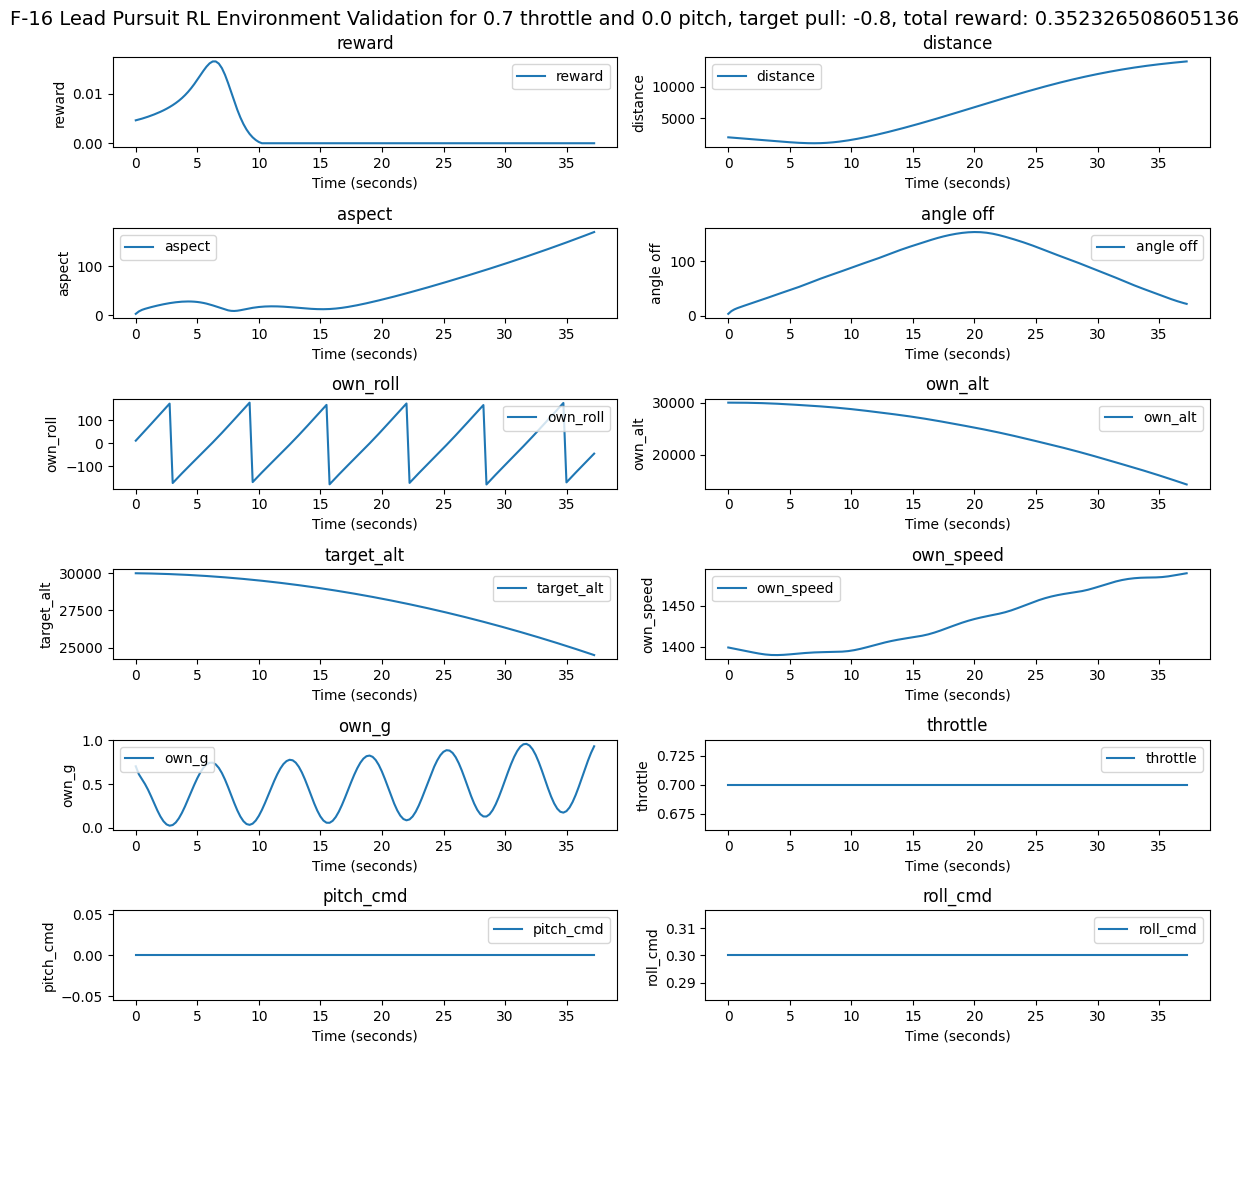

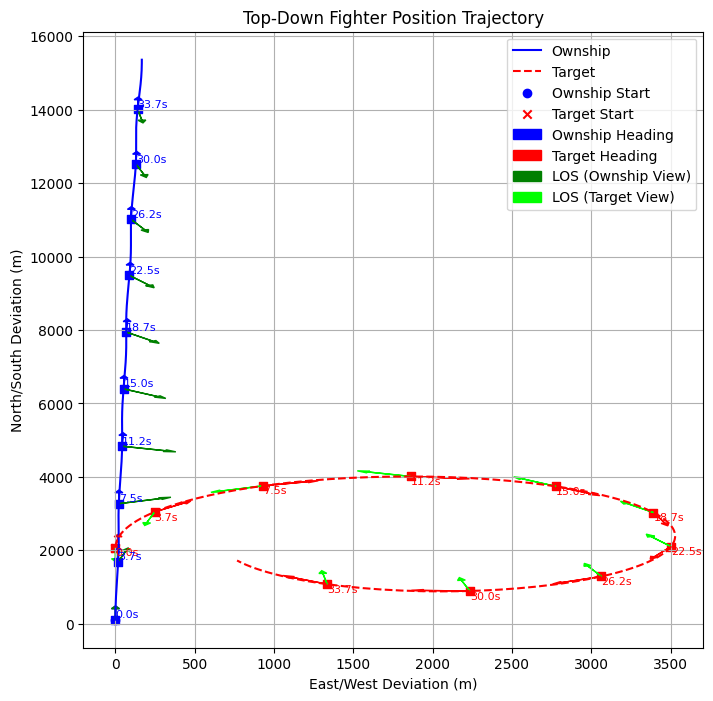

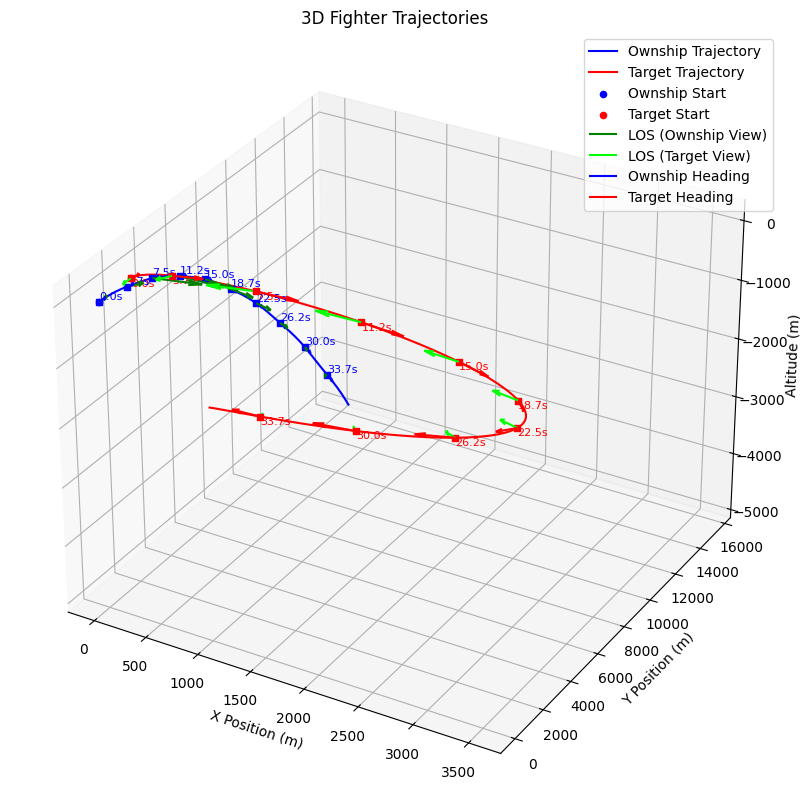

using fixed action for throttle 0.7 and pitch -0.3
Initial conditions set. Starting simulation...
initial observation [ 2.1908919e-13  1.0000000e+00 -2.9313621e-10  3.9974710e-01
  6.1232343e-17  1.0000000e+00  5.6047810e-07  6.1232343e-17
  1.0000000e+00  3.6030735e-07  5.0000000e-01  5.0000000e-01
  1.3999453e+03  9.0005963e+02]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5 

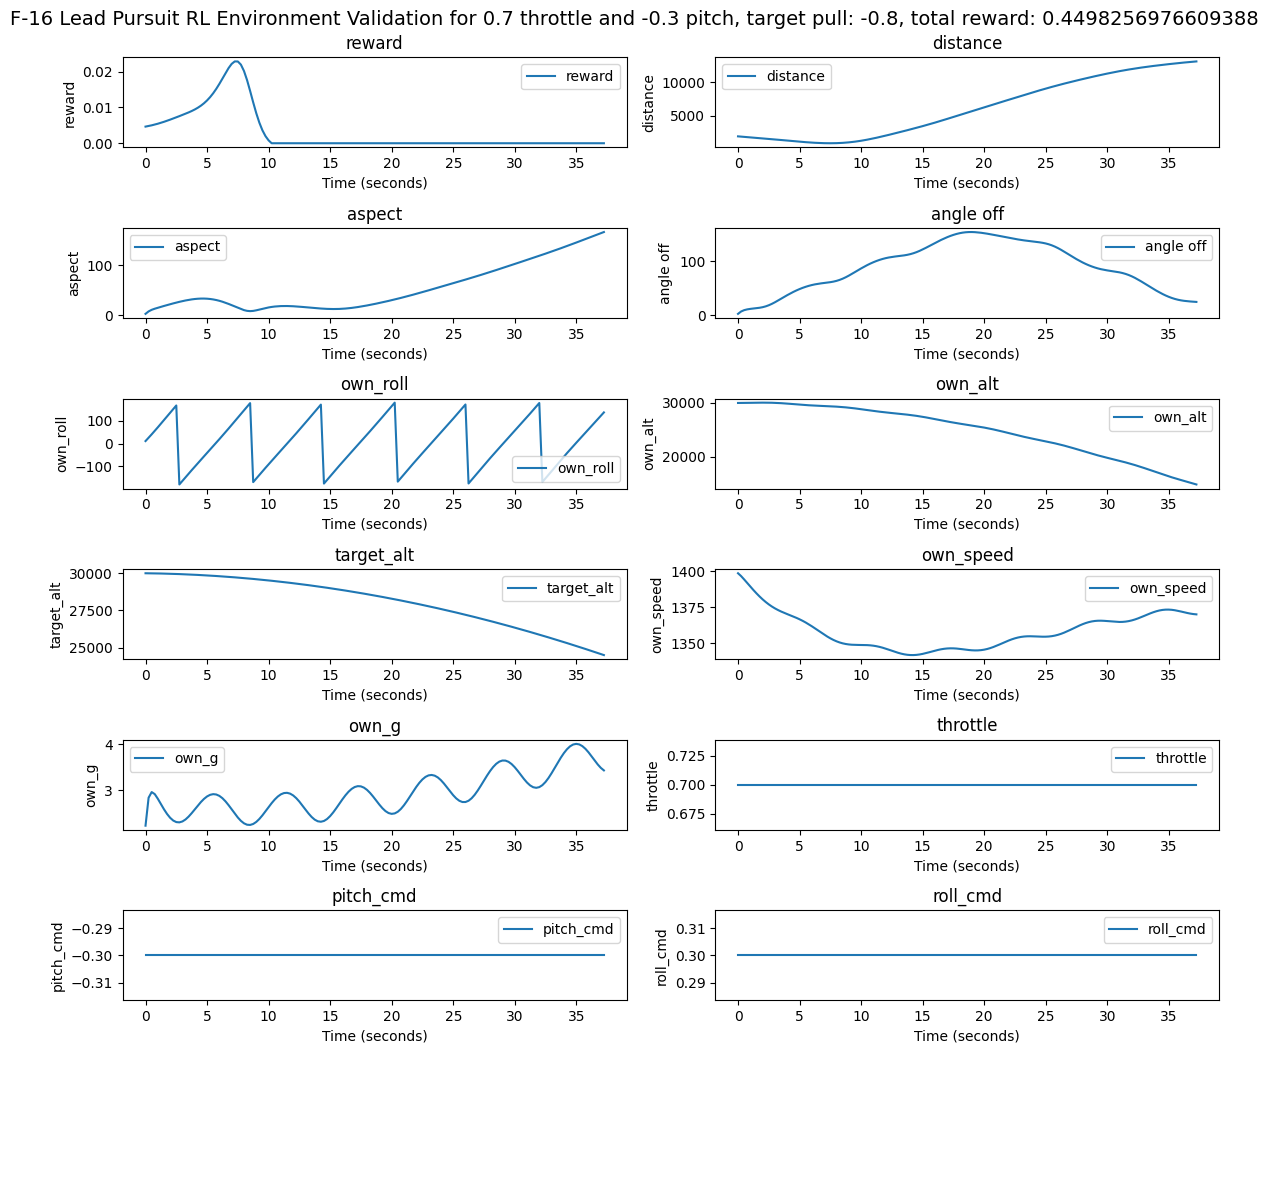

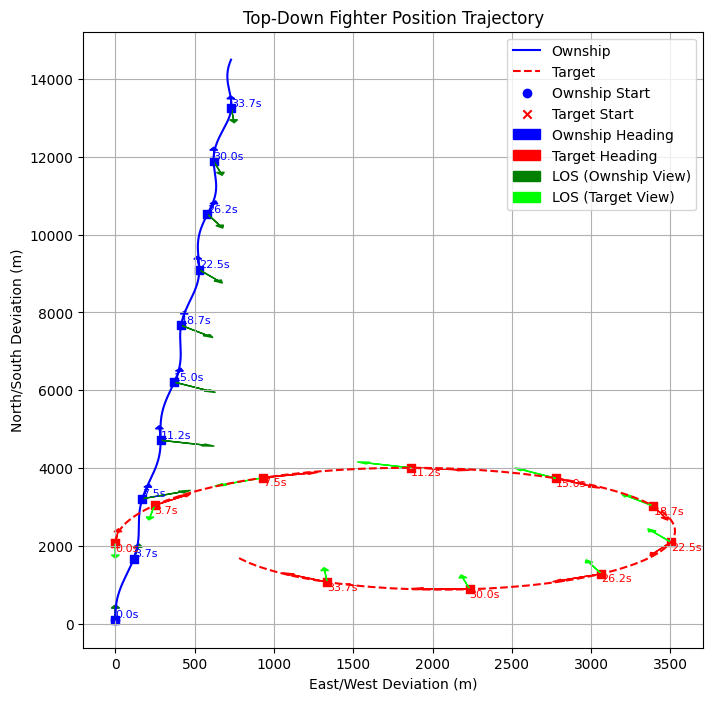

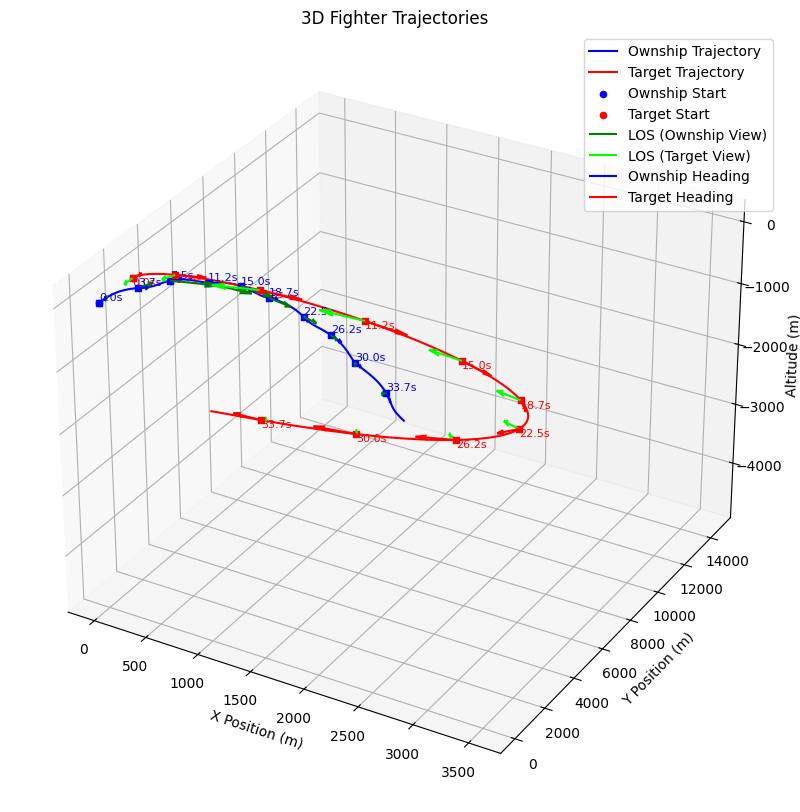

using fixed action for throttle 0.7 and pitch -0.6
Initial conditions set. Starting simulation...
initial observation [ 2.1908919e-13  1.0000000e+00 -2.9313621e-10  3.9974710e-01
  6.1232343e-17  1.0000000e+00  5.6047810e-07  6.1232343e-17
  1.0000000e+00  3.6030735e-07  5.0000000e-01  5.0000000e-01
  1.3999453e+03  9.0005963e+02]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5 

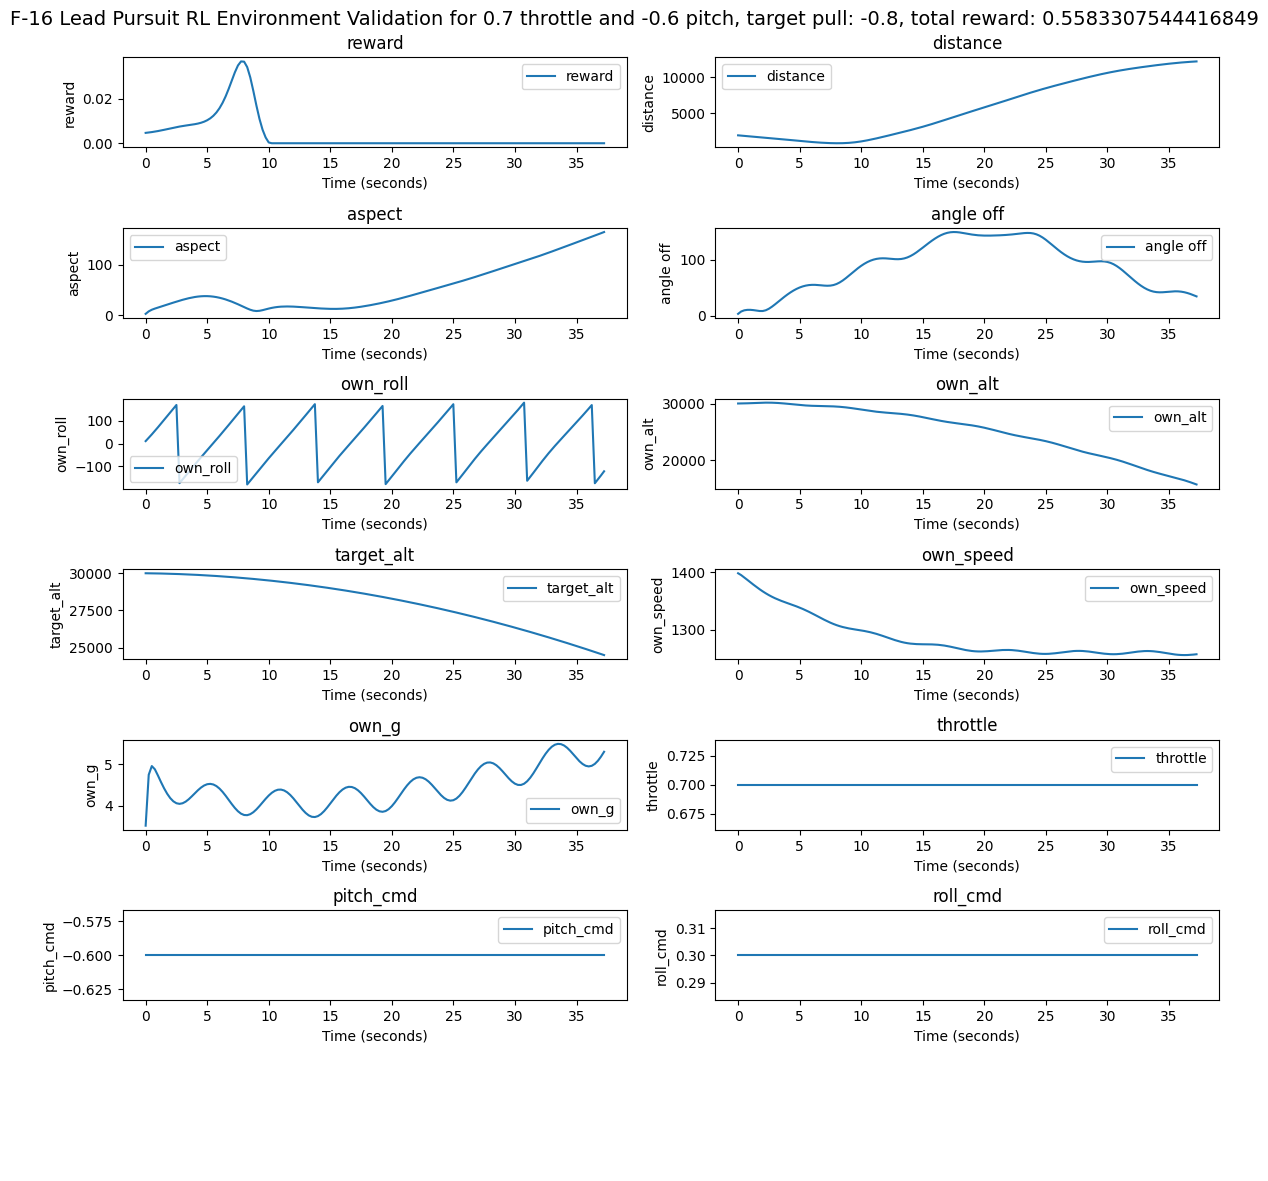

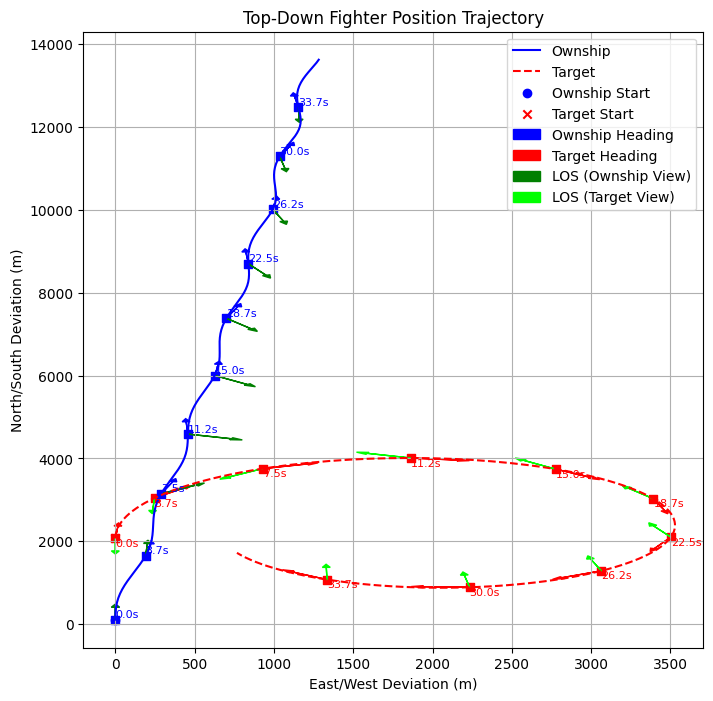

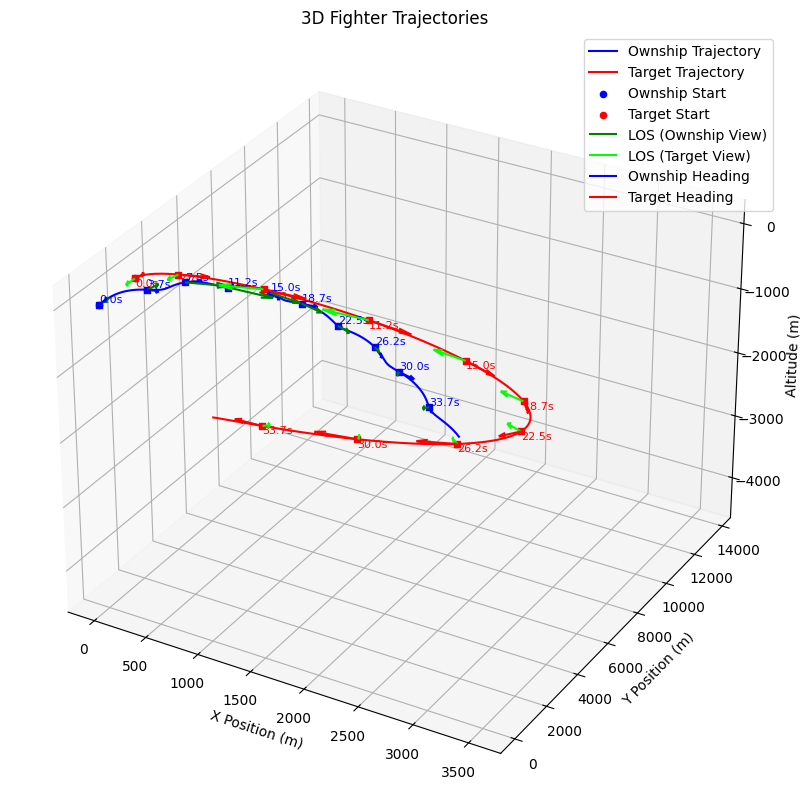

using fixed action for throttle 0.7 and pitch -0.9
Initial conditions set. Starting simulation...
initial observation [ 2.1908919e-13  1.0000000e+00 -2.9313621e-10  3.9974710e-01
  6.1232343e-17  1.0000000e+00  5.6047810e-07  6.1232343e-17
  1.0000000e+00  3.6030735e-07  5.0000000e-01  5.0000000e-01
  1.3999453e+03  9.0005963e+02]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                                  1500  -174.4     -65       5 

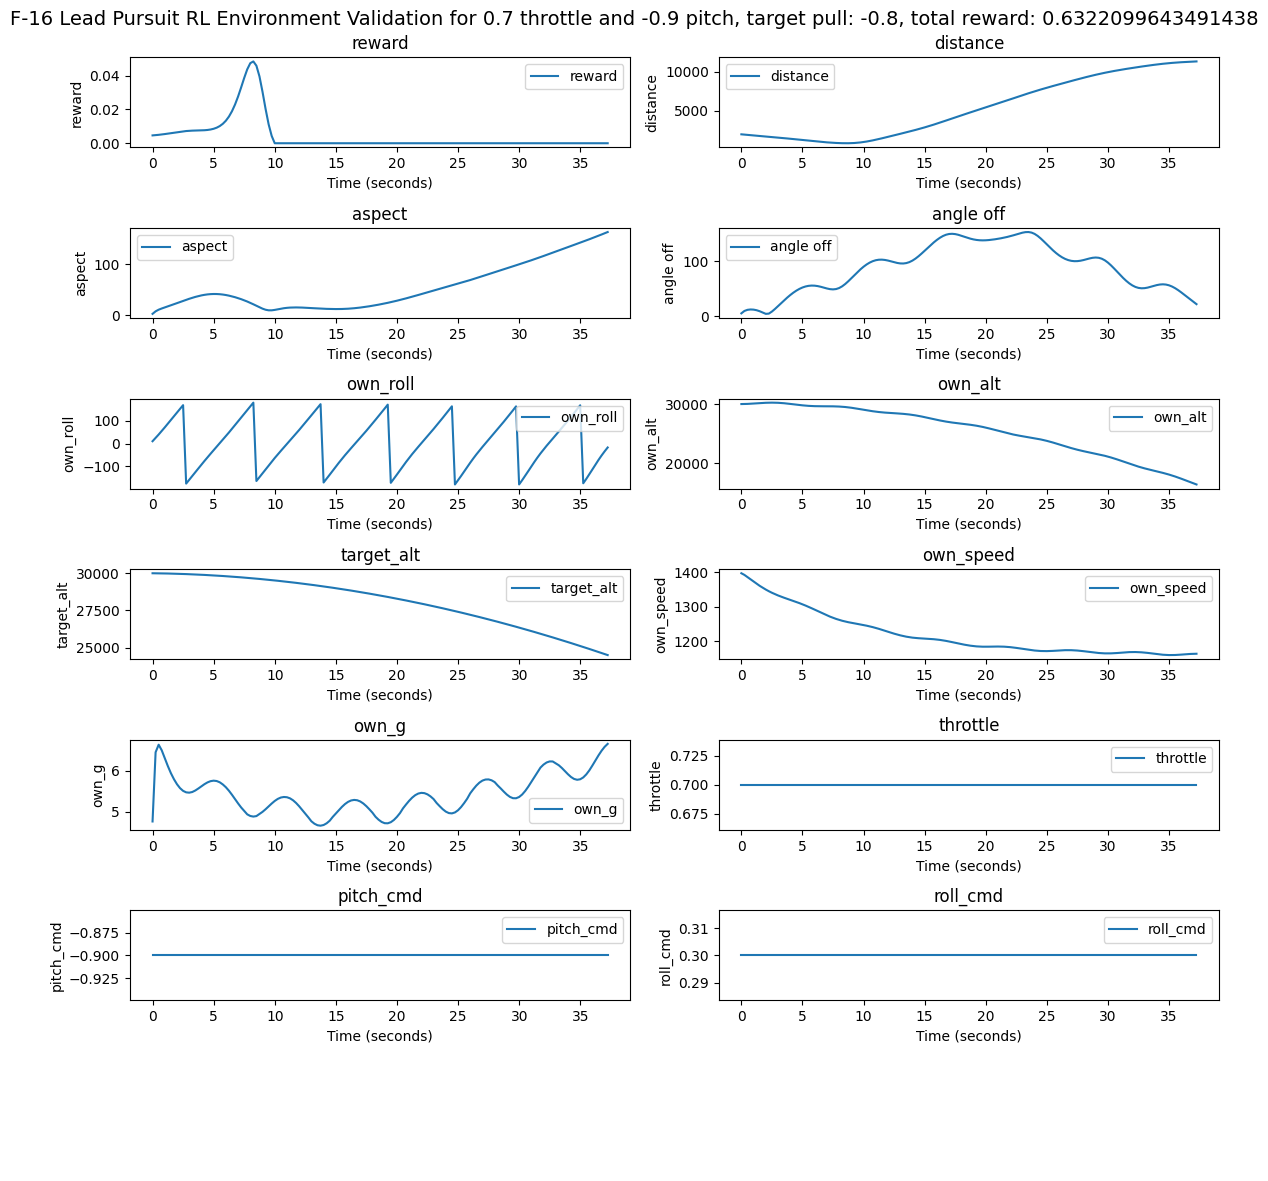

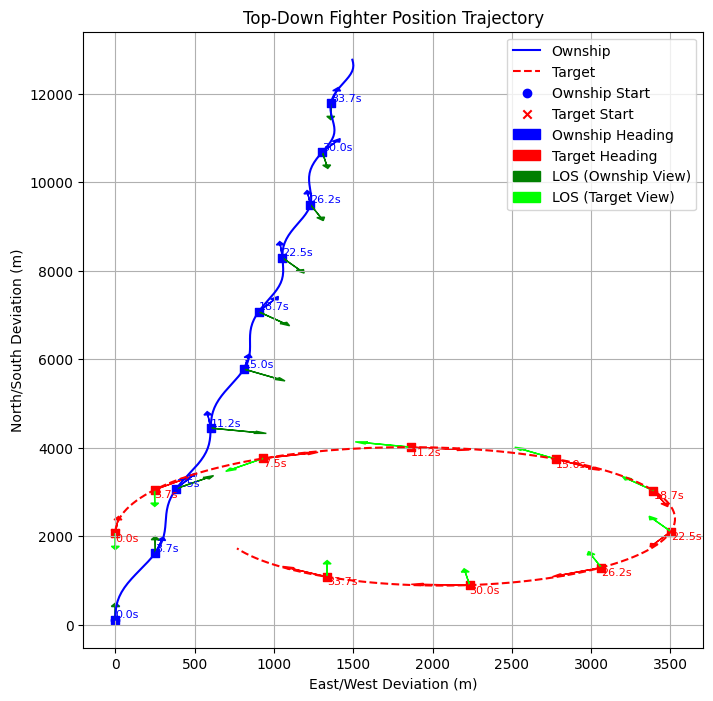

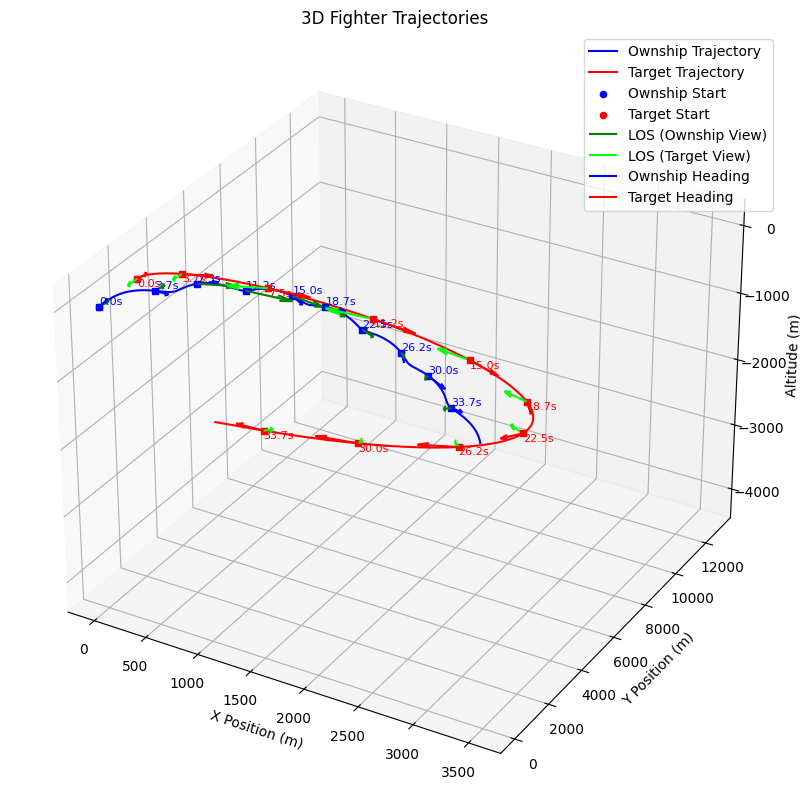

In [73]:
for pitch in [0.0, -0.3, -0.6, -0.9]:
    testEnvironment(fixed_action=np.array([0.7, pitch, 0.3]), time_in_seconds=True)

/home/sezhou/aienv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


loaded model:  ./f16_leadpursuit_checkpoints_0323/f16_3d_lead_pursuit_1500_steps.zip
Initial conditions set. Starting simulation...
initial observation [ 2.1908919e-13  1.0000000e+00 -2.9313621e-10  3.9974710e-01
  6.1232343e-17  1.0000000e+00  5.6047810e-07  6.1232343e-17
  1.0000000e+00  3.6030735e-07  5.0000000e-01  5.0000000e-01
  1.3999453e+03  9.0005963e+02]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                             

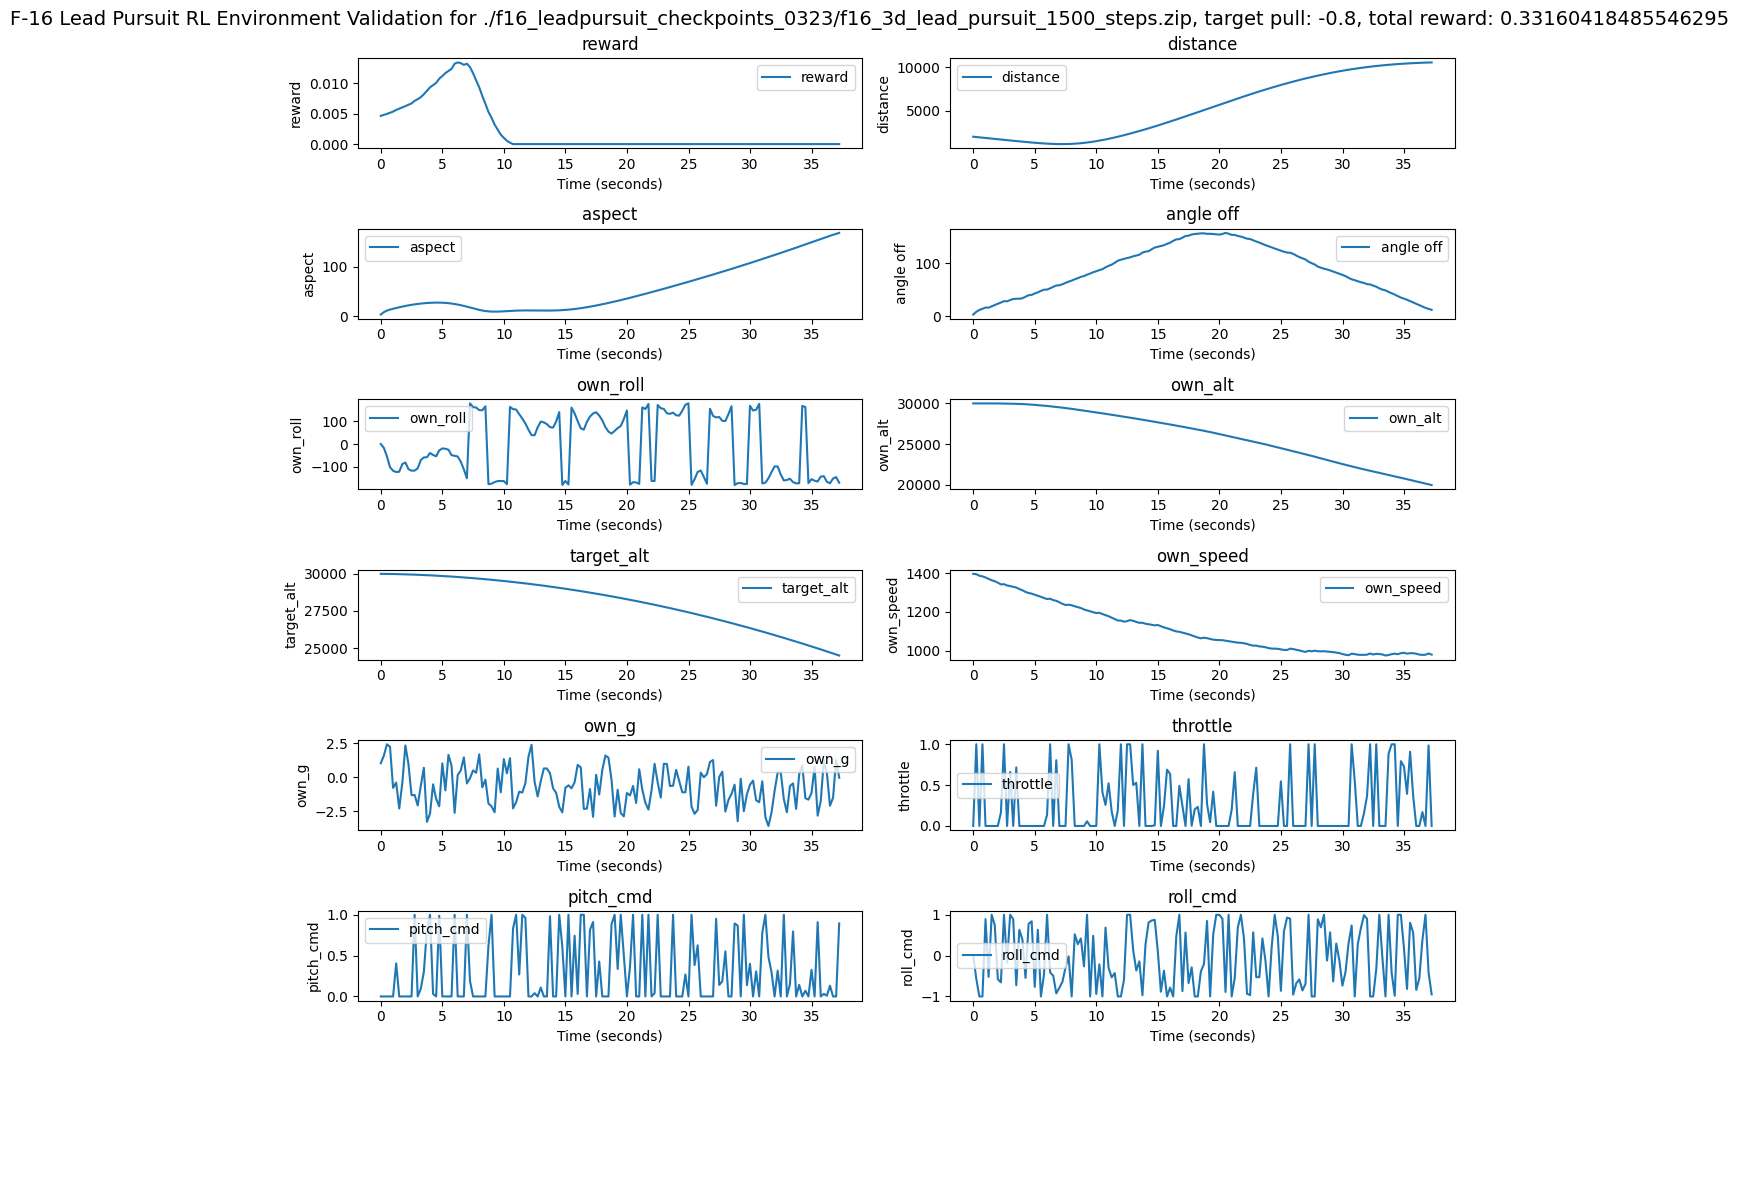

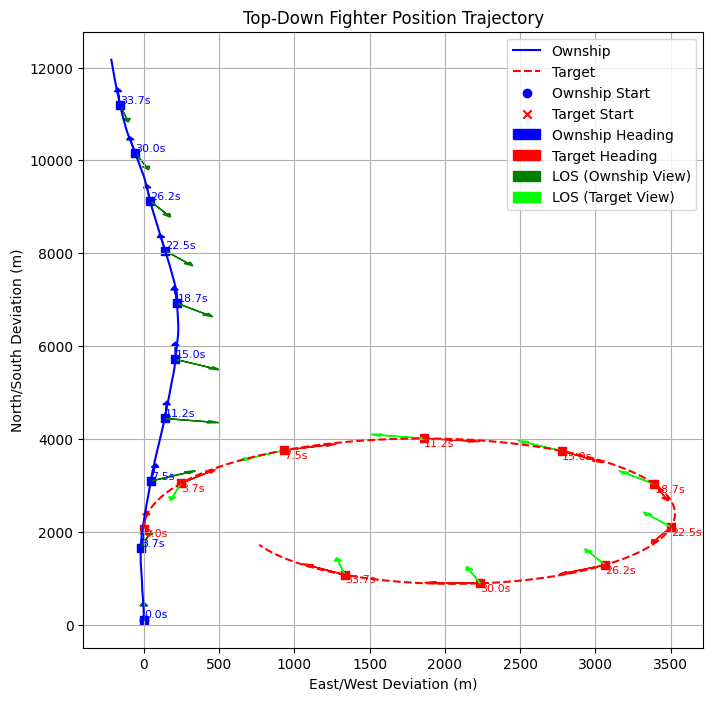

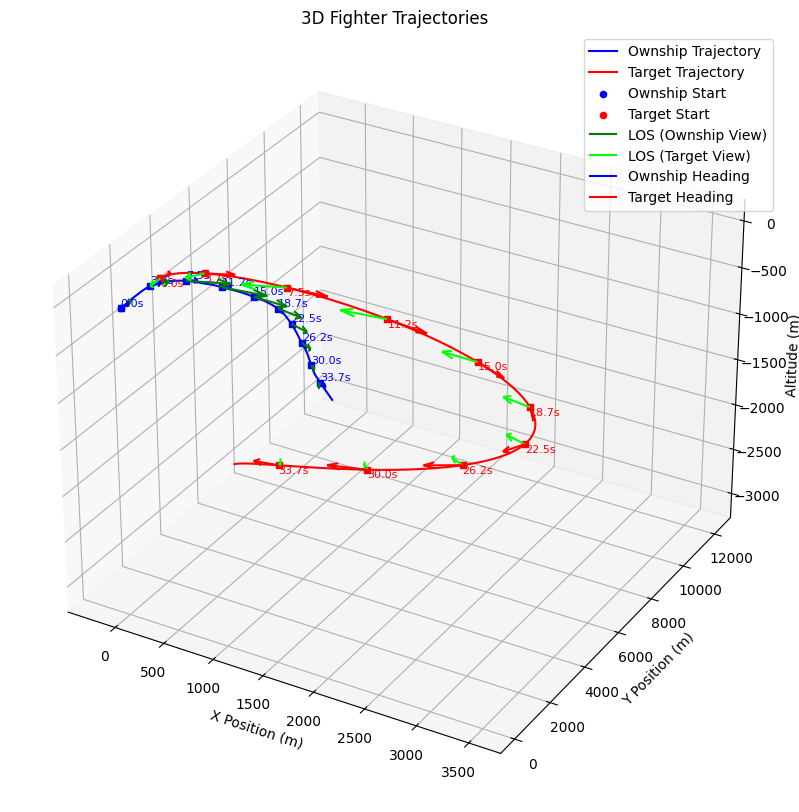

loaded model:  ./f16_leadpursuit_checkpoints_0323/f16_3d_lead_pursuit_25500_steps.zip
Initial conditions set. Starting simulation...

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle  initial observation [ 2.1908919e-13  1.0000000e+00 -2.9313621e-10  3.9974710e-01
  6.1232343e-17  1.0000000e+00  5.6047810e-07  6.1232343e-17
  1.0000000e+00  3.6030735e-07  5.0000000e-01  5.0000000e-01
  1.3999453e+03  9.0005963e+02]
                     17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                            

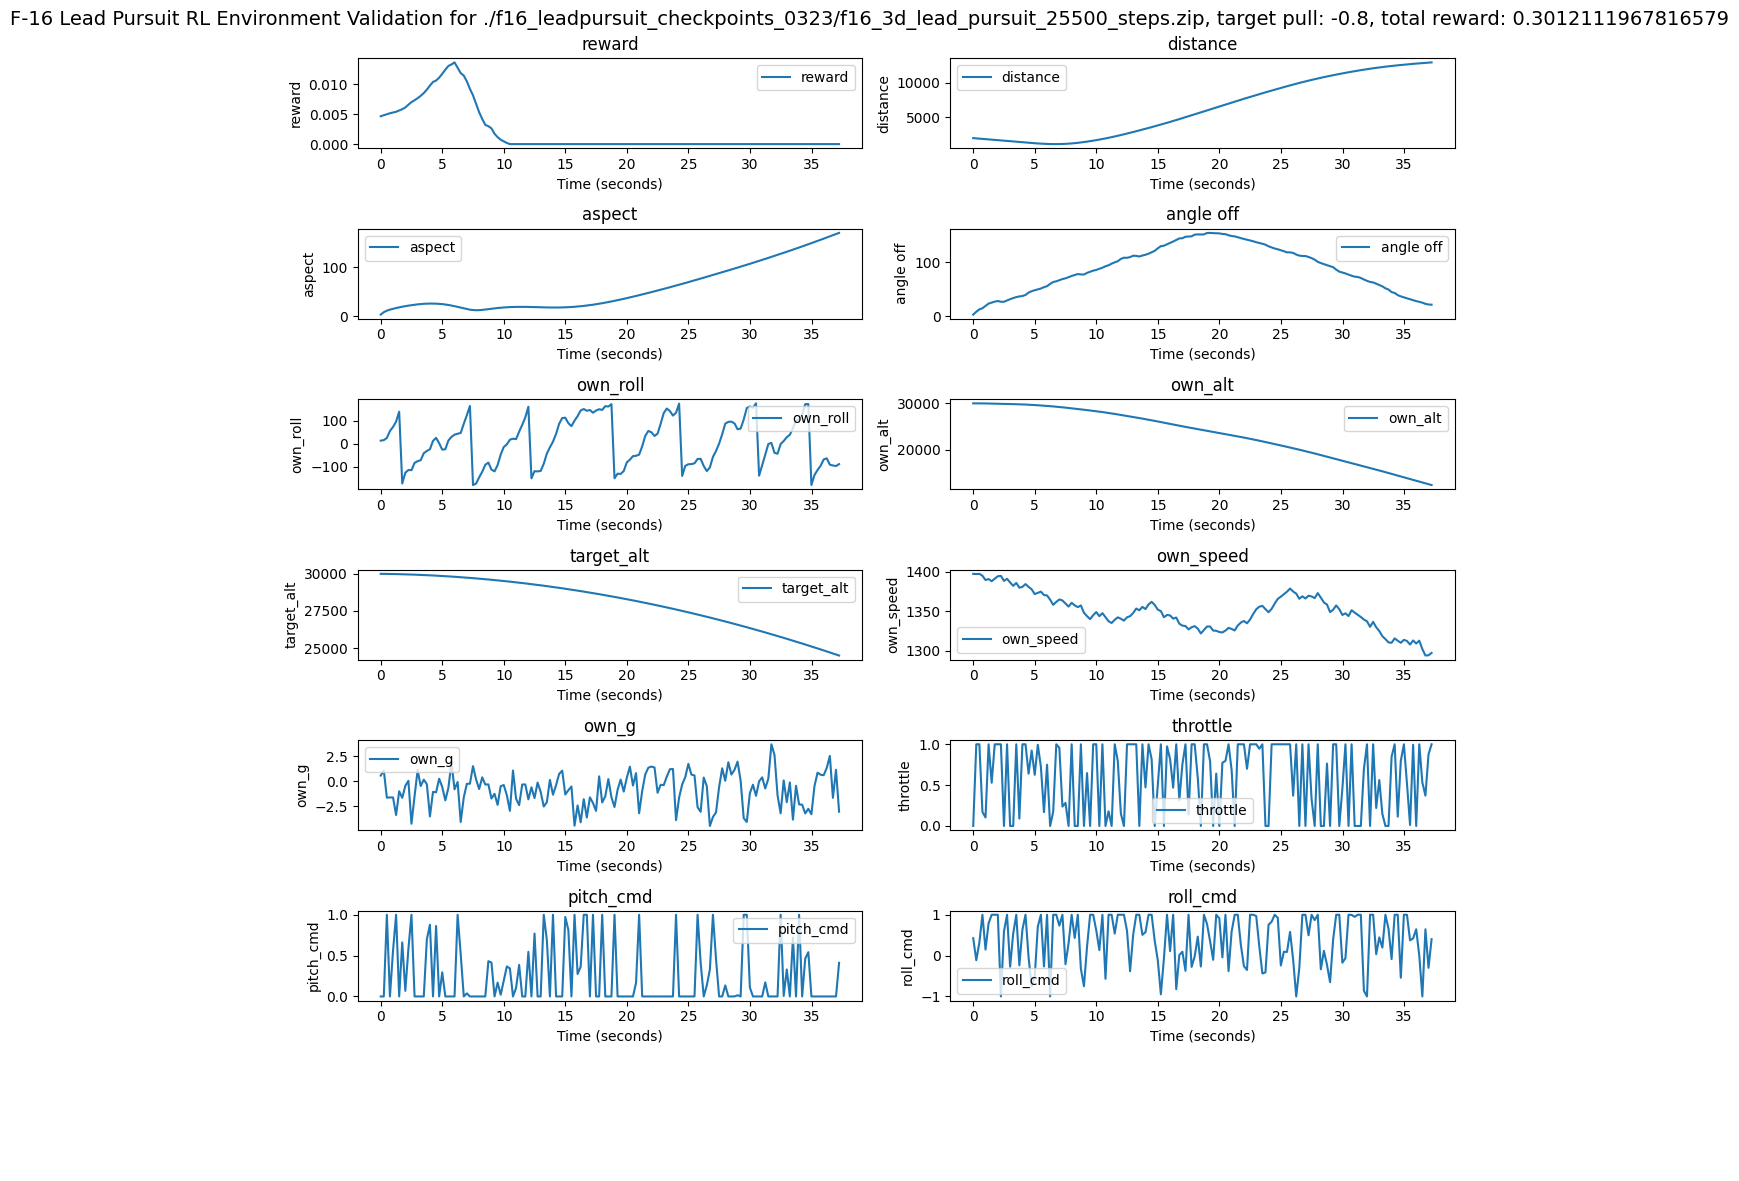

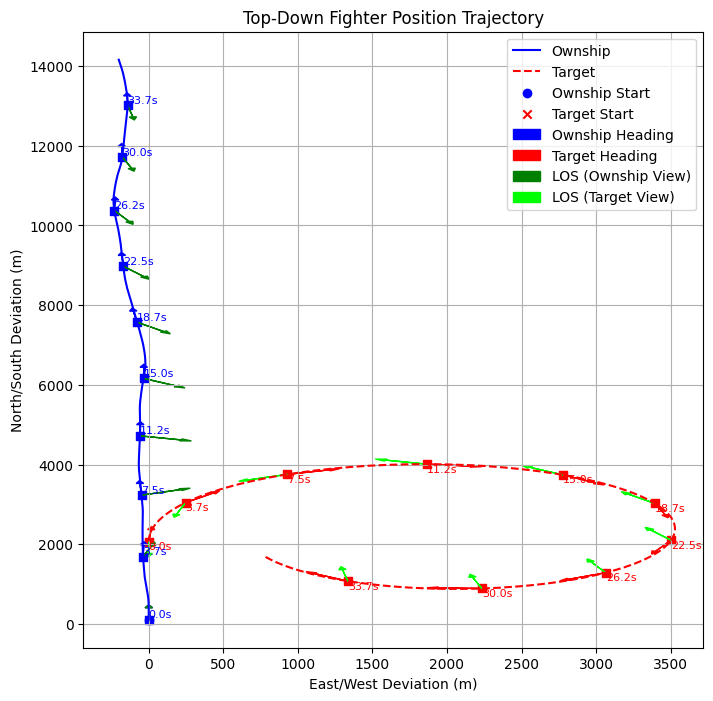

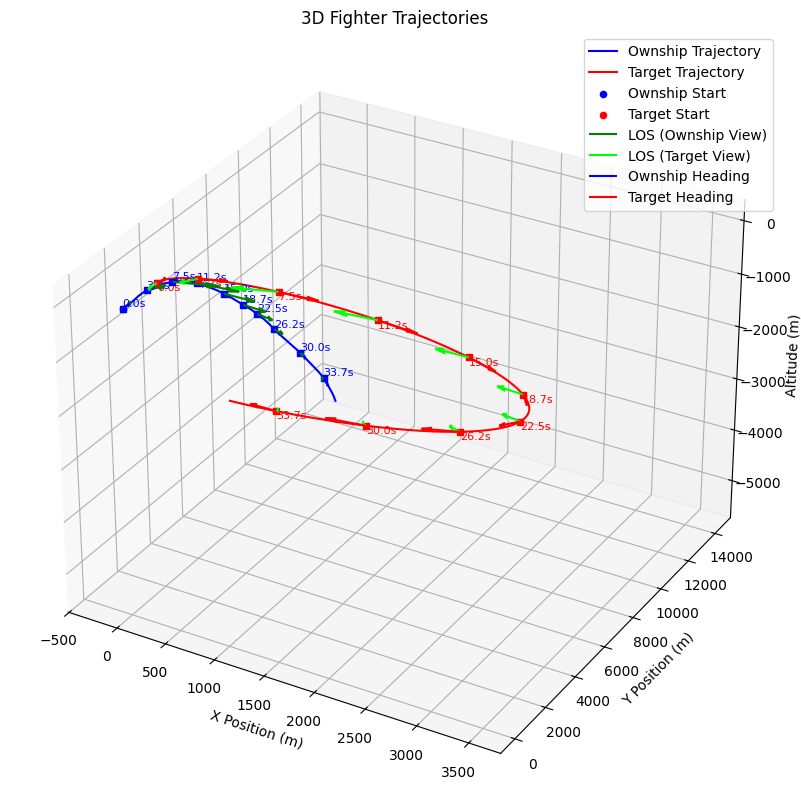

loaded model:  ./f16_leadpursuit_checkpoints_0323/f16_3d_lead_pursuit_49500_steps.zip
Initial conditions set. Starting simulation...

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                  initial observation [ 2.1908919e-13  1.0000000e+00 -2.9313621e-10  3.9974710e-01
  6.1232343e-17  1.0000000e+00  5.6047810e-07  6.1232343e-17
  1.0000000e+00  3.6030735e-07  5.0000000e-01  5.0000000e-01
  1.3999453e+03  9.0005963e+02]
    Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                            

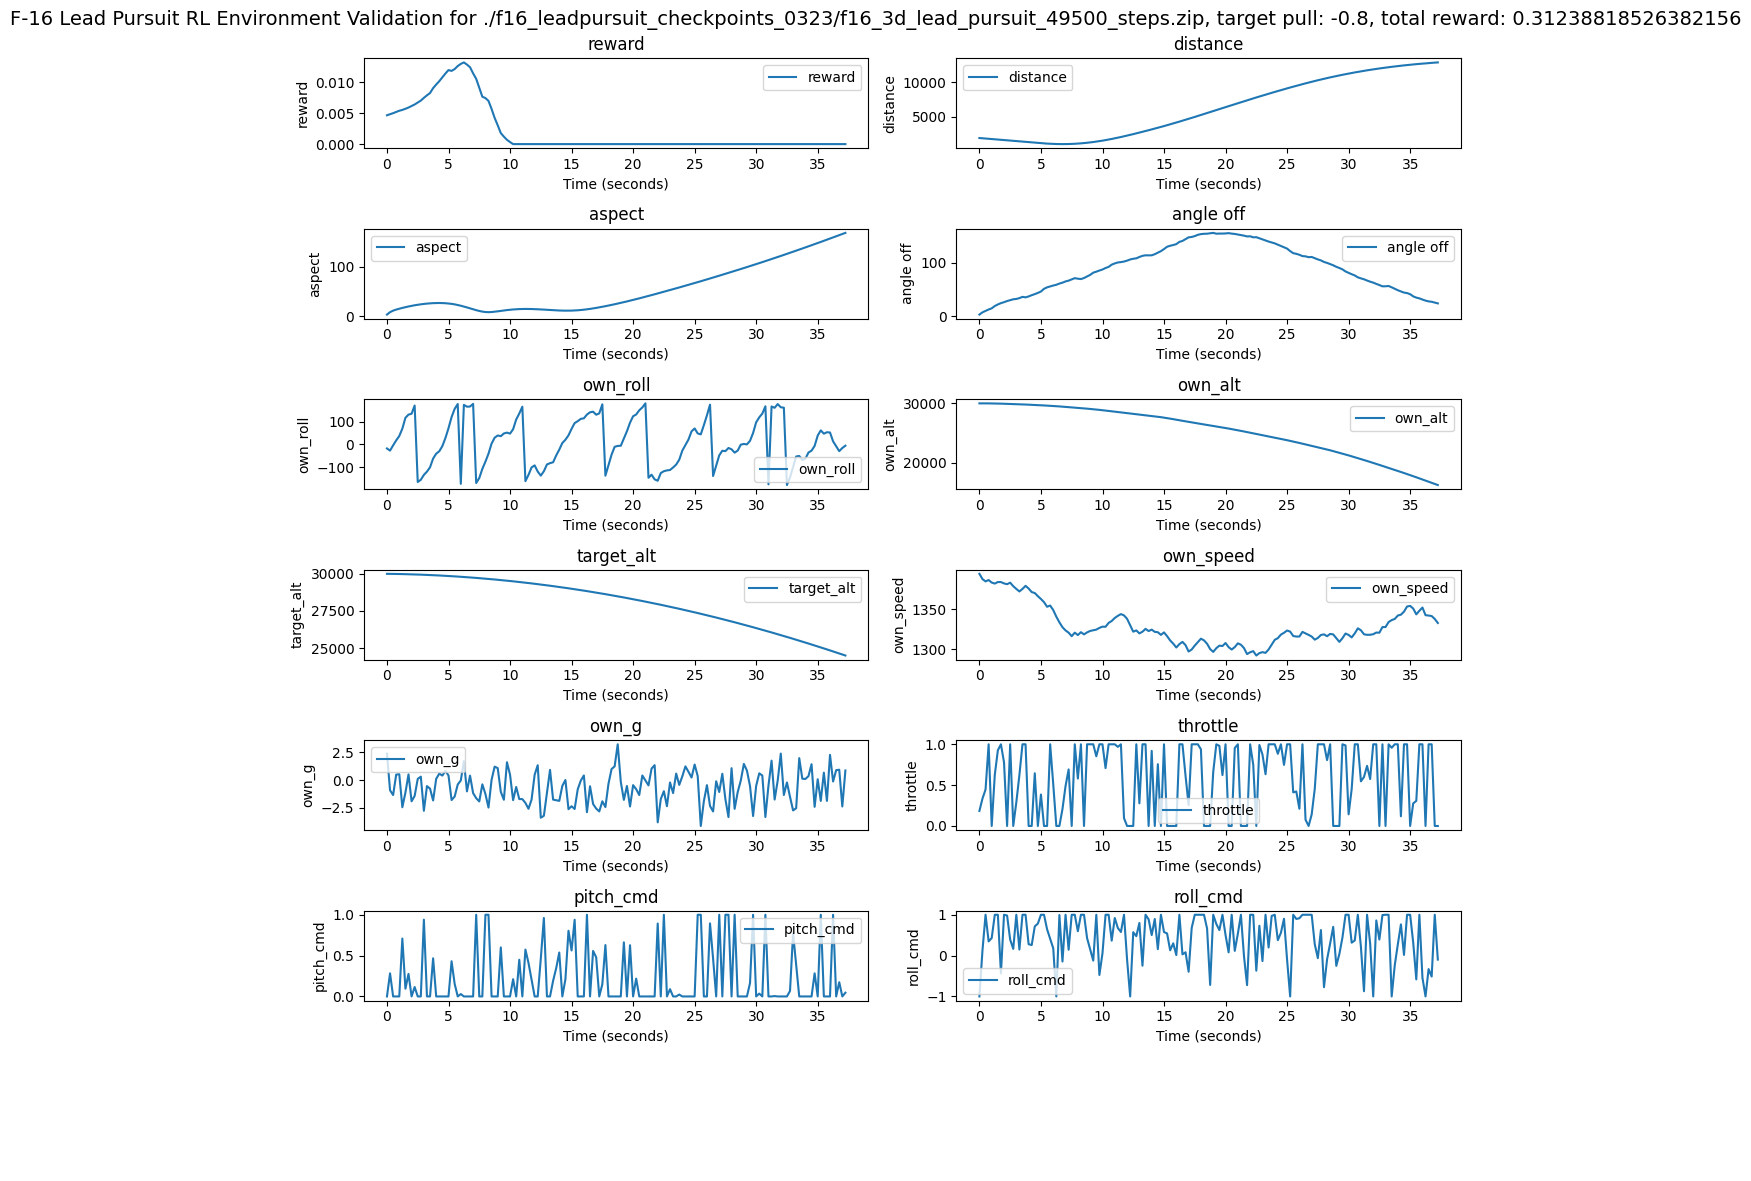

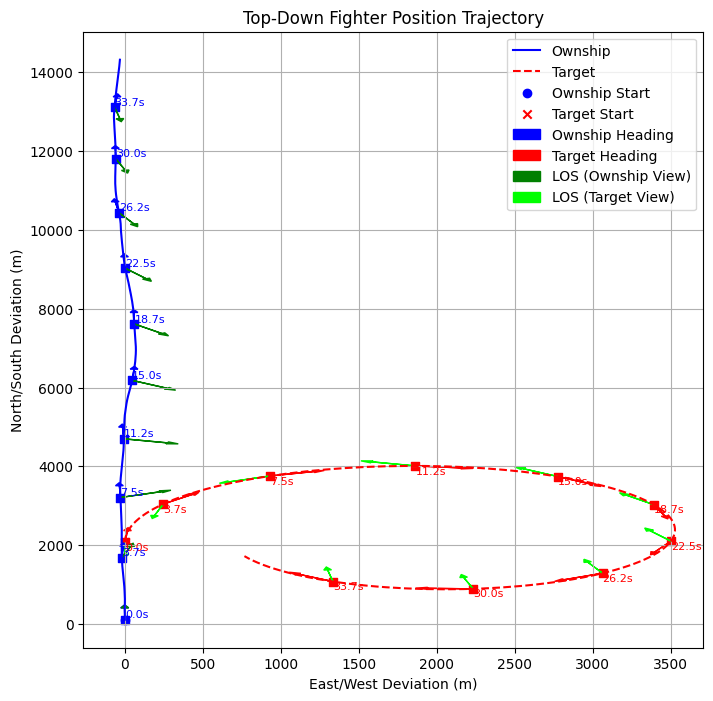

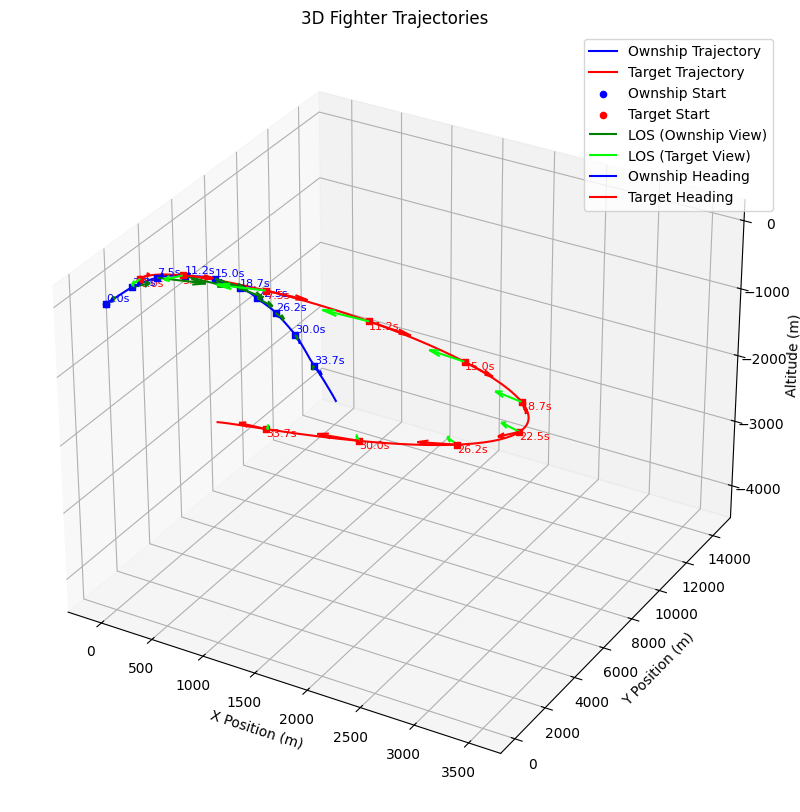

loaded model:  ./f16_leadpursuit_checkpoints_0323/f16_3d_lead_pursuit_73500_steps.zip
Initial conditions set. Starting simulation...
initial observation [ 2.1908919e-13  1.0000000e+00 -2.9313621e-10  3.9974710e-01
  6.1232343e-17  1.0000000e+00  5.6047810e-07  6.1232343e-17
  1.0000000e+00  3.6030735e-07  5.0000000e-01  5.0000000e-01
  1.3999453e+03  9.0005963e+02]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                            

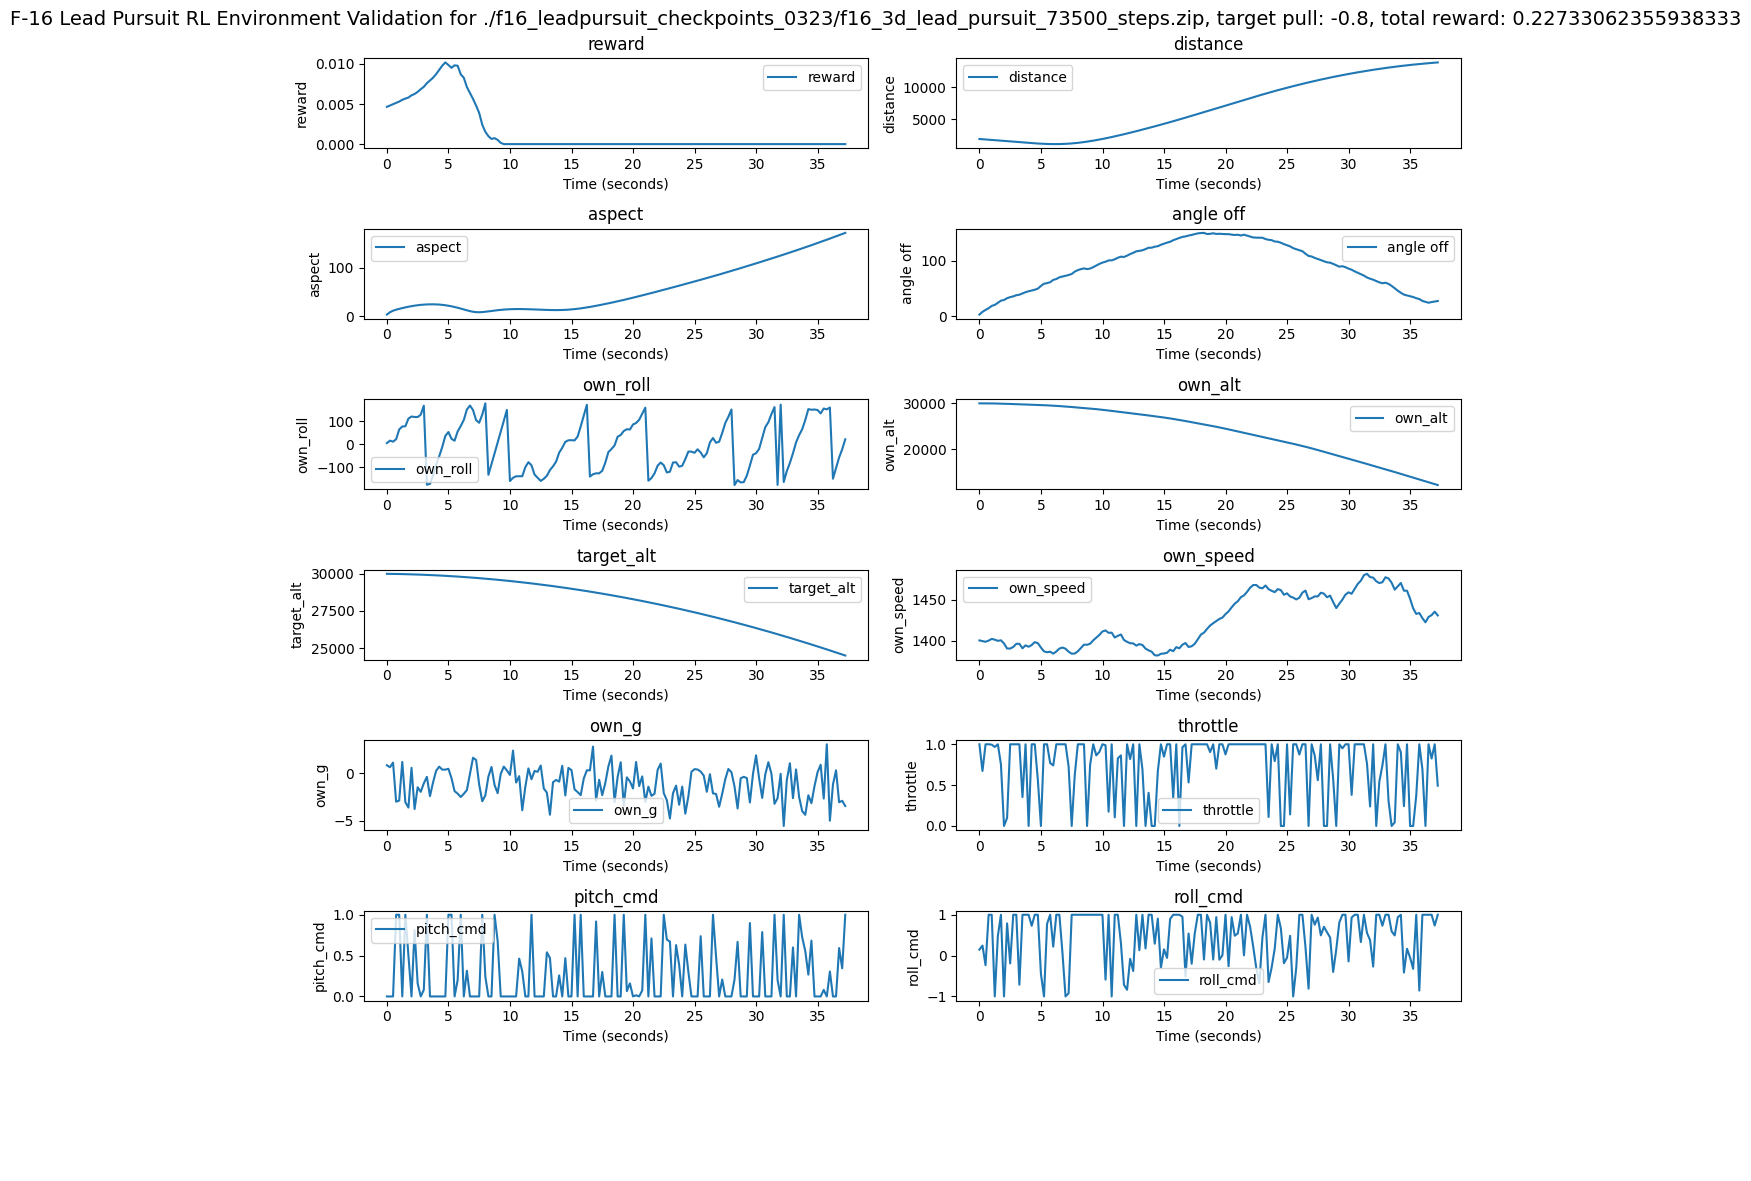

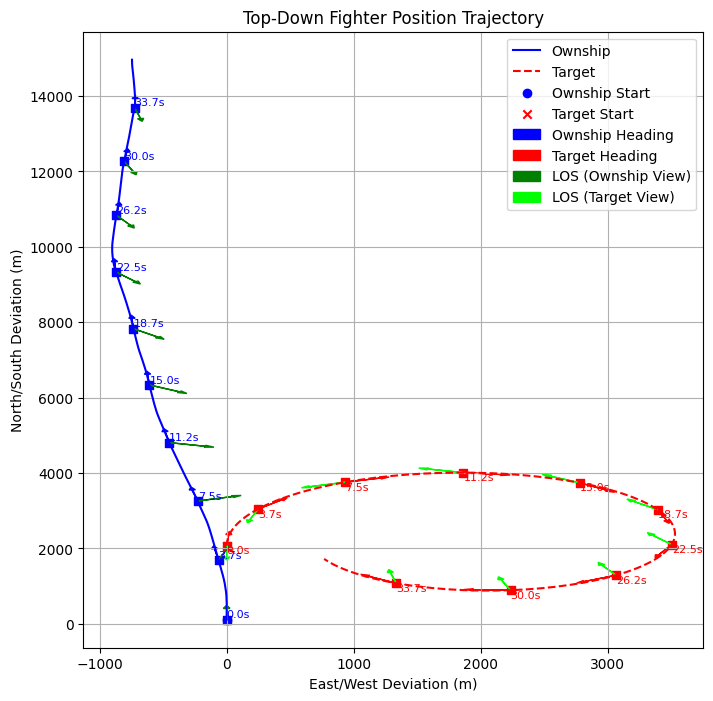

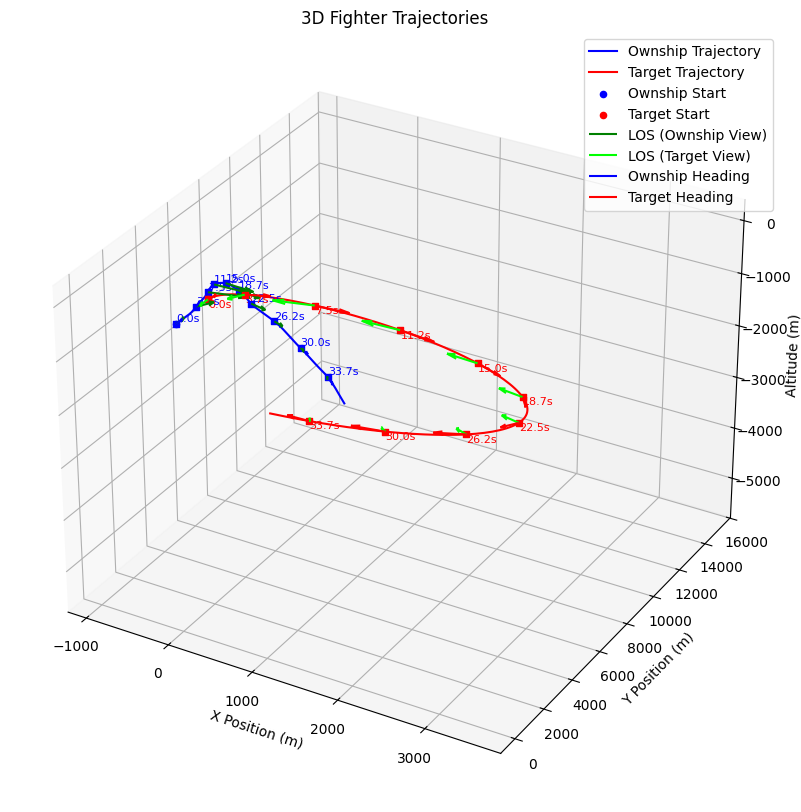

loaded model:  ./f16_leadpursuit_checkpoints_0323/f16_3d_lead_pursuit_97500_steps.zip
Initial conditions set. Starting simulation...
initial observation [ 2.1908919e-13  1.0000000e+00 -2.9313621e-10  3.9974710e-01
  6.1232343e-17  1.0000000e+00  5.6047810e-07  6.1232343e-17
  1.0000000e+00  3.6030735e-07  5.0000000e-01  5.0000000e-01
  1.3999453e+03  9.0005963e+02]

  Mass Properties Report (English units: lbf, in, slug-ft^2)
                                      Weight    CG-X    CG-Y    CG-Z         Ixx         Iyy         Izz         Ixy         Ixz         Iyz
    Base Vehicle                       17400.0  -193.0     0.0    -5.1      9496.0     55814.0     63100.0        -0.0      -982.0        -0.0
0   Pilot                                230.0  -336.2     0.0     0.0         0.0         0.0         0.0        -0.0         0.0        -0.0
0   Fuel                                  1500  -174.4      65       5           0           0           0
1   Fuel                            

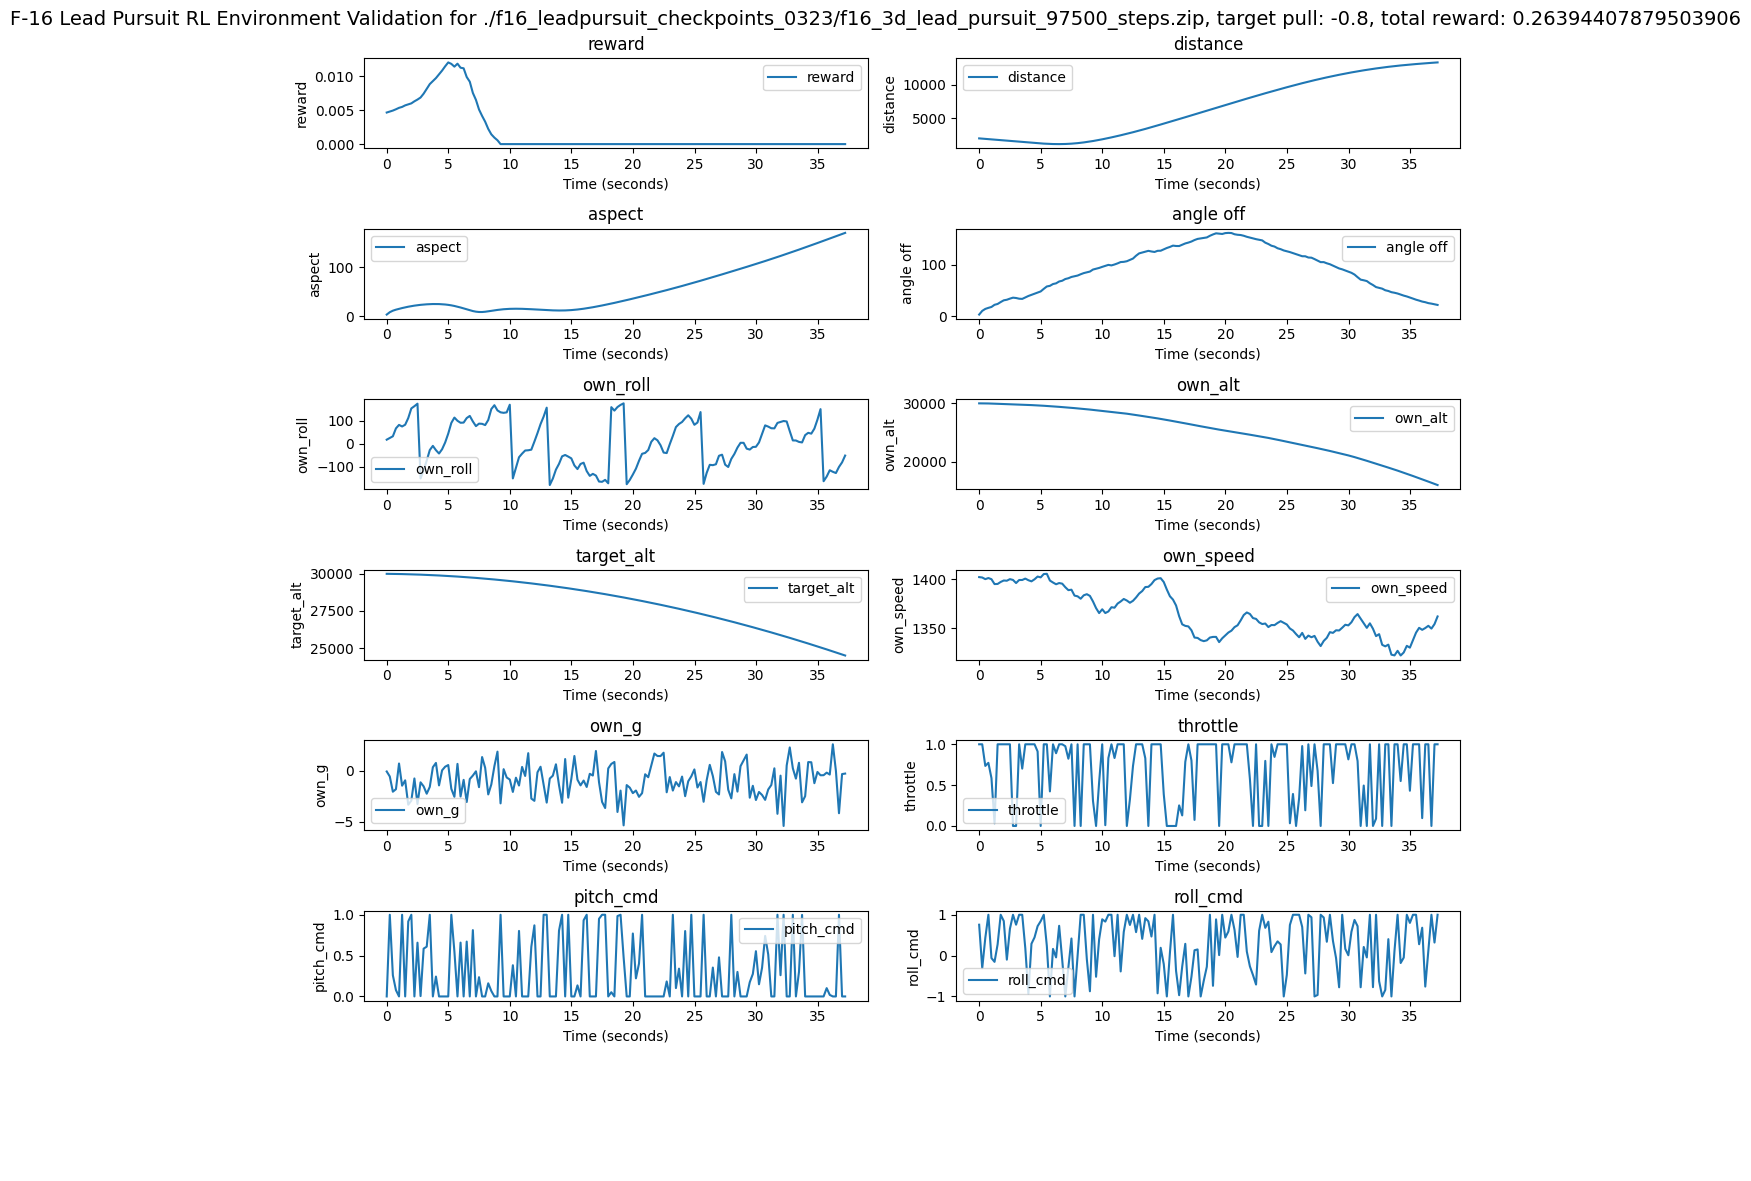

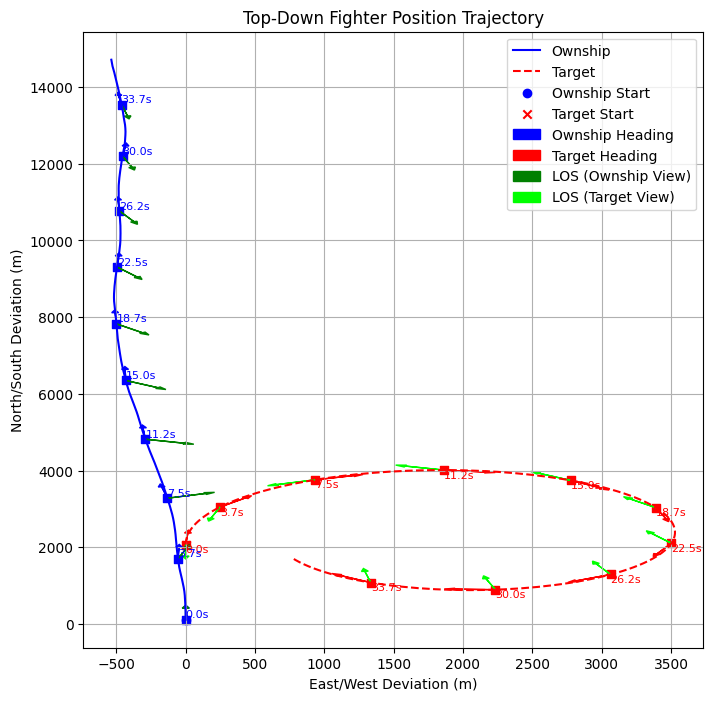

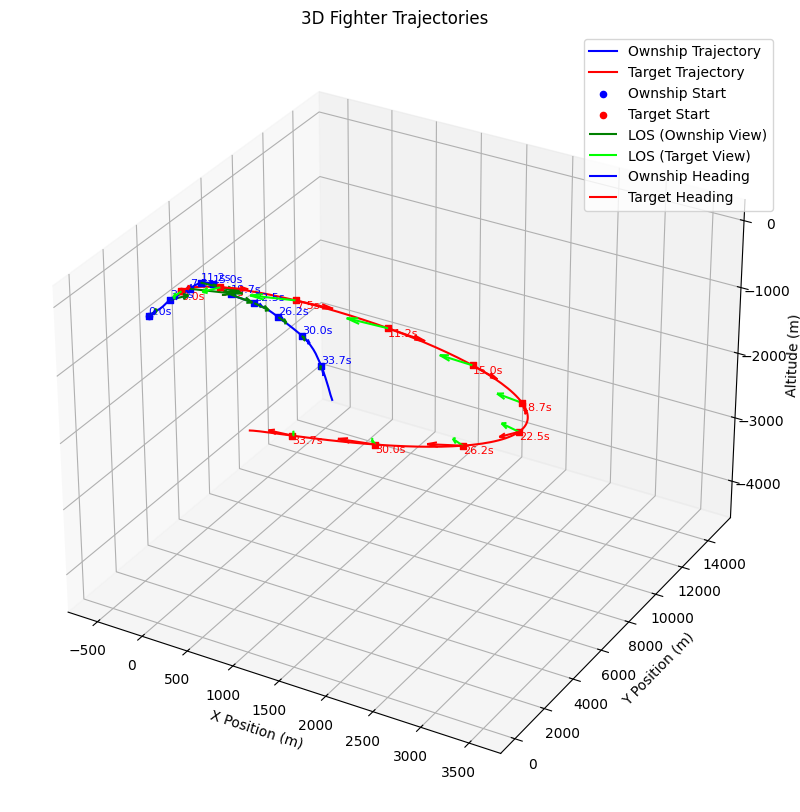

In [74]:
step = 1500
while step <= 120000:
    testEnvironment(model_path=f"./f16_leadpursuit_checkpoints_0323/f16_3d_lead_pursuit_{step}_steps.zip", time_in_seconds=True)
    step += 24000